In [ ]:
'''Required packages, install as needed'''
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install statsmodels
!pip install arch

In [ ]:
'''Skip this segment, for loading data from GCP bucket'''
from google.cloud import storage

storage_client = storage.Client()

bucket_name = 'vi-fund'

bucket = storage_client.get_bucket(bucket_name)

blobs = bucket.list_blobs()

for blob in blobs:
    file_name = blob.name
    blob.download_to_filename(file_name)

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
import arch

In [124]:
df = pd.read_excel('10 Yr Hardware and Software.xlsx')
df.head(10)

,Start Period,End Period,Ticker Code,Company Name,Share Price Return % (QTR),Market Cap,Daily Liquidity,Short Interest,RSI,Past 3M Return,...,"Price Volatility, 3","Price Volatility, 6",SMA 50,SMA 100,SMA 150,SMA 200,Avg 3 RSI,Avg 6 RSI,Avg 12 RSI,"Avg 3,6,12 RSI"
0,2010-12-31,2011-03-31,NYSE:ACN,Accenture plc,13.3600,31064,235.6,0,62.8,14.1,...,23.3234,21.2078,45.58,43.32,41.85,41.8,61.856576,57.874369,53.533407,57.754784
1,2010-12-31,2011-03-31,NasdaqGS:ADBE,Adobe Inc.,7.7300,15658,264.7,0,62.1,17.7,...,34.7297,44.9217,29.06,28.77,29.04,30.35,52.201444,50.265873,47.881376,50.116231
2,2010-12-31,2011-03-31,NasdaqGS:ADTN,"ADTRAN, Inc.",17.2604,2284,36.8,3,72.9,2.6,...,25.752,28.451,33.35,33.12,31.83,30.64,54.030546,57.427889,57.125619,56.194685
3,2010-12-31,2011-03-31,NasdaqGS:AKAM,"Akamai Technologies, Inc.",-19.2300,8579,241.7,1,37.2,-6.2,...,37.3781,40.8456,50.37,49.11,46.91,44.05,50.251298,53.641522,58.050712,53.981178
4,2010-12-31,2011-03-31,NYSE:ADS,Alliance Data Systems Corporation,20.9200,3693,57.2,5,66.6,8.8,...,26.2327,33.7621,65.49,63.72,63.21,64.82,56.501573,52.852267,52.903225,54.085688
5,2010-12-31,2011-03-31,NasdaqGS:DOX,Amdocs Limited,5.0200,5268,42.3,0,57.7,-4.2,...,23.3439,23.7297,27.48,27.58,27.64,28.38,49.995548,50.014628,50.683041,50.231072
6,2010-12-31,2011-03-31,NYSE:APH,Amphenol Corporation,3.0504,9216,42.3,1,54.3,7.8,...,21.5541,27.0027,12.91,12.21,11.66,11.49,58.251410,57.384194,53.047095,56.227566
7,2010-12-31,2011-03-31,IQ281893,Anixter International Inc.,17.0099,2027,20.7,2,57.6,10.6,...,28.3308,28.1095,57.49,53.91,51.17,50.78,59.302994,57.736923,54.208635,57.082851
8,2010-12-31,2011-03-31,NasdaqGS:ANSS,"ANSYS, Inc.",4.0700,4738,27.6,1,57.5,23.2,...,23.1811,25.6777,49.3,45.65,44.86,44.72,64.205314,57.006641,54.197192,58.469716
9,2010-12-31,2011-03-31,NasdaqGS:AAPL,Apple Inc.,8.0443,295887,4864.7,0,56.3,13.7,...,19.4354,20.6924,11.26,10.49,10.07,9.76,62.354649,58.487030,58.675704,59.839128


Doing standard data exploration here

In [ ]:
df.info()

In [ ]:
df.describe()

Creating list of target and factor columns

In [125]:
cols = list(df.columns)
cols.remove("Start Period")
cols.remove("End Period")
cols.remove("Ticker Code")
cols.remove("Company Name")
cols

['Share Price Return % (QTR)',
 'Market Cap',
 'Daily Liquidity',
 'Short Interest',
 'RSI',
 'Past 3M Return',
 'Past 6M Return',
 'Past 12M Return',
 'Avg 3/6/12M Return',
 'STA',
 'SNOA',
 'PROBM to PMAN',
 'PFD (X100)',
 'Altman Z, LTM/FY',
 'TBV',
 'Net Debt/Total Common Equity',
 'Intangible Asset Ratio',
 'ORECTA',
 'EV/EBIT',
 'EV/EBITDA',
 'EV/S',
 'P/B',
 ' EV ',
 'GP',
 'EV/GP',
 'P/S',
 'GPTA',
 'GPTA, -1',
 'GPTA, -2',
 'GPTA, -3',
 'GPTA Avg',
 'GP/Capital',
 'GP/Capital, -1',
 'GP/Capital, -2',
 'GP/Capital, -3',
 'GP/Capital Avg',
 'GPM',
 'GPM, -1',
 'GPM, -2',
 'GPM, -3',
 'GPM, -4',
 'GPM, -5',
 'GPM, -6',
 'GPM, -7',
 'GPM, -8',
 'Avg Margin Growth',
 'Margin Stability',
 'Avg Rev Growth',
 '(Rev Growth) Growth Slope',
 'Rev Stability S.D',
 'Avg GP Growth',
 '(GP Growth) Growth Slope',
 'GP Stability S.D',
 'Beta, 24',
 'Price Volatility, 3',
 'Price Volatility, 6',
 'SMA 50',
 'SMA 100',
 'SMA 150',
 'SMA 200',
 'Avg 3 RSI',
 'Avg 6 RSI',
 'Avg 12 RSI',
 'Avg 3,6,

In [126]:
temp_df = df[cols]

In [127]:
temp_df.head()

,Share Price Return % (QTR),Market Cap,Daily Liquidity,Short Interest,RSI,Past 3M Return,Past 6M Return,Past 12M Return,Avg 3/6/12M Return,STA,...,"Price Volatility, 3","Price Volatility, 6",SMA 50,SMA 100,SMA 150,SMA 200,Avg 3 RSI,Avg 6 RSI,Avg 12 RSI,"Avg 3,6,12 RSI"
0,13.3600,31064,235.6,0,62.8,14.1,25.5,16.8,18.8,-0.0371,...,23.3234,21.2078,45.58,43.32,41.85,41.8,61.856576,57.874369,53.533407,57.754784
1,7.7300,15658,264.7,0,62.1,17.7,16.5,-16.3,6.0,-0.0046,...,34.7297,44.9217,29.06,28.77,29.04,30.35,52.201444,50.265873,47.881376,50.116231
2,17.2604,2284,36.8,3,72.9,2.6,32.8,60.6,32.0,0.0256,...,25.752,28.451,33.35,33.12,31.83,30.64,54.030546,57.427889,57.125619,56.194685
3,-19.2300,8579,241.7,1,37.2,-6.2,16.0,85.7,31.8,-0.0403,...,37.3781,40.8456,50.37,49.11,46.91,44.05,50.251298,53.641522,58.050712,53.981178
4,20.9200,3693,57.2,5,66.6,8.8,19.3,10.0,12.7,0.4384,...,26.2327,33.7621,65.49,63.72,63.21,64.82,56.501573,52.852267,52.903225,54.085688


This section is focused on cleaning the dataset, ie. substituting the missing values and string values with 0.

In [128]:
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
temp_df = imputer.fit_transform(temp_df)

In [129]:
temp_df = temp_df.T
df_arr = pd.DataFrame(temp_df, cols)


In [130]:
df_arr = df_arr.transpose()

In [131]:
df_arr.head()

,Share Price Return % (QTR),Market Cap,Daily Liquidity,Short Interest,RSI,Past 3M Return,Past 6M Return,Past 12M Return,Avg 3/6/12M Return,STA,...,"Price Volatility, 3","Price Volatility, 6",SMA 50,SMA 100,SMA 150,SMA 200,Avg 3 RSI,Avg 6 RSI,Avg 12 RSI,"Avg 3,6,12 RSI"
0,13.36,31064,235.6,0,62.8,14.1,25.5,16.8,18.8,-0.0371,...,23.3234,21.2078,45.58,43.32,41.85,41.8,61.856576,57.874369,53.533407,57.754784
1,7.73,15658,264.7,0,62.1,17.7,16.5,-16.3,6.0,-0.0046,...,34.7297,44.9217,29.06,28.77,29.04,30.35,52.201444,50.265873,47.881376,50.116231
2,17.2604,2284,36.8,3,72.9,2.6,32.8,60.6,32.0,0.0256,...,25.752,28.451,33.35,33.12,31.83,30.64,54.030546,57.427889,57.125619,56.194685
3,-19.23,8579,241.7,1,37.2,-6.2,16.0,85.7,31.8,-0.0403,...,37.3781,40.8456,50.37,49.11,46.91,44.05,50.251298,53.641522,58.050712,53.981178
4,20.92,3693,57.2,5,66.6,8.8,19.3,10.0,12.7,0.4384,...,26.2327,33.7621,65.49,63.72,63.21,64.82,56.501573,52.852267,52.903225,54.085688


In [132]:
df_arr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8515 entries, 0 to 8514
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Share Price Return % (QTR)    8515 non-null   object
 1   Market Cap                    8515 non-null   object
 2   Daily Liquidity               8515 non-null   object
 3   Short Interest                8515 non-null   object
 4   RSI                           8515 non-null   object
 5   Past 3M Return                8515 non-null   object
 6   Past 6M Return                8515 non-null   object
 7   Past 12M Return               8515 non-null   object
 8   Avg 3/6/12M Return            8515 non-null   object
 9   STA                           8515 non-null   object
 10  SNOA                          8515 non-null   object
 11  PROBM to PMAN                 8515 non-null   object
 12  PFD (X100)                    8515 non-null   object
 13  Altman Z, LTM/FY  

In [133]:
imputer = SimpleImputer(missing_values="NM", strategy="constant", fill_value=0)
temp_arr = imputer.fit_transform(df_arr)

In [134]:
new_df = pd.DataFrame(temp_arr.T, cols)

In [135]:
new_df = new_df.T

In [136]:
for var in new_df.columns:
    try:
        new_df[var].astype("float")
    except:
        print(f"{var} is string")

GPM, -8 is string
(Rev Growth) Growth Slope is string
Rev Stability S.D is string
(GP Growth) Growth Slope is string
GP Stability S.D is string
Beta, 24 is string
Price Volatility, 3 is string
Price Volatility, 6 is string
SMA 50 is string
SMA 100 is string
SMA 150 is string
SMA 200 is string


In [137]:
imputer = SimpleImputer(missing_values=new_df["GPM, -8"][98], strategy="constant", fill_value=0)
arr = imputer.fit_transform(new_df)

In [138]:
arr

array([[13.36, 31064, 235.6, ..., 57.8743688, 53.5334068, 57.75478393],
       [7.73, 15658, 264.7, ..., 50.2658728, 47.8813764, 50.11623121],
       [17.2604, 2284, 36.8, ..., 57.4278888, 57.1256188, 56.19468454],
       ...,
       [-37.21, 759, 12.9, ..., 59.1725432, 51.6468128, 59.31299274],
       [-50.0438, 3850, 330.7, ..., 0, 0, 55.65829365],
       [-52.5, 13299, 1563.7, ..., 0, 0, 0]], dtype=object)

In [139]:
final_df = pd.DataFrame(arr.T, cols)
final_df = final_df.T

In [140]:
final_df.head()

,Share Price Return % (QTR),Market Cap,Daily Liquidity,Short Interest,RSI,Past 3M Return,Past 6M Return,Past 12M Return,Avg 3/6/12M Return,STA,...,"Price Volatility, 3","Price Volatility, 6",SMA 50,SMA 100,SMA 150,SMA 200,Avg 3 RSI,Avg 6 RSI,Avg 12 RSI,"Avg 3,6,12 RSI"
0,13.36,31064,235.6,0,62.8,14.1,25.5,16.8,18.8,-0.0371,...,23.3234,21.2078,45.58,43.32,41.85,41.8,61.856576,57.874369,53.533407,57.754784
1,7.73,15658,264.7,0,62.1,17.7,16.5,-16.3,6.0,-0.0046,...,34.7297,44.9217,29.06,28.77,29.04,30.35,52.201444,50.265873,47.881376,50.116231
2,17.2604,2284,36.8,3,72.9,2.6,32.8,60.6,32.0,0.0256,...,25.752,28.451,33.35,33.12,31.83,30.64,54.030546,57.427889,57.125619,56.194685
3,-19.23,8579,241.7,1,37.2,-6.2,16.0,85.7,31.8,-0.0403,...,37.3781,40.8456,50.37,49.11,46.91,44.05,50.251298,53.641522,58.050712,53.981178
4,20.92,3693,57.2,5,66.6,8.8,19.3,10.0,12.7,0.4384,...,26.2327,33.7621,65.49,63.72,63.21,64.82,56.501573,52.852267,52.903225,54.085688


In [141]:
for var in final_df.columns:
    for val in final_df[var]:
        if isinstance(val, str):
            print(var)
            break

(Rev Growth) Growth Slope
(GP Growth) Growth Slope
Beta, 24
Price Volatility, 3
Price Volatility, 6


In [142]:
fault_vars = ["(Rev Growth) Growth Slope", "(GP Growth) Growth Slope", "Beta, 24", "Price Volatility, 3", "Price Volatility, 6"]
fault_indices = []
for var in fault_vars: 
    for i in range(len(final_df[var])):
        if isinstance(final_df[var][i], str):
            fault_indices.append(i)
            break                
assert(len(fault_indices) == len(fault_vars))

In [143]:
for i in range(len(fault_vars)):
    imputer = SimpleImputer(missing_values=final_df[fault_vars[i]][fault_indices[i]], strategy="constant", fill_value=0)
    arr = imputer.fit_transform(final_df)
    final_df = pd.DataFrame(arr.T, cols)
    final_df = final_df.T

In [144]:
final_df.head()

,Share Price Return % (QTR),Market Cap,Daily Liquidity,Short Interest,RSI,Past 3M Return,Past 6M Return,Past 12M Return,Avg 3/6/12M Return,STA,...,"Price Volatility, 3","Price Volatility, 6",SMA 50,SMA 100,SMA 150,SMA 200,Avg 3 RSI,Avg 6 RSI,Avg 12 RSI,"Avg 3,6,12 RSI"
0,13.36,31064,235.6,0,62.8,14.1,25.5,16.8,18.8,-0.0371,...,23.3234,21.2078,45.58,43.32,41.85,41.8,61.856576,57.874369,53.533407,57.754784
1,7.73,15658,264.7,0,62.1,17.7,16.5,-16.3,6.0,-0.0046,...,34.7297,44.9217,29.06,28.77,29.04,30.35,52.201444,50.265873,47.881376,50.116231
2,17.2604,2284,36.8,3,72.9,2.6,32.8,60.6,32.0,0.0256,...,25.752,28.451,33.35,33.12,31.83,30.64,54.030546,57.427889,57.125619,56.194685
3,-19.23,8579,241.7,1,37.2,-6.2,16.0,85.7,31.8,-0.0403,...,37.3781,40.8456,50.37,49.11,46.91,44.05,50.251298,53.641522,58.050712,53.981178
4,20.92,3693,57.2,5,66.6,8.8,19.3,10.0,12.7,0.4384,...,26.2327,33.7621,65.49,63.72,63.21,64.82,56.501573,52.852267,52.903225,54.085688


In [145]:
for var in final_df:
    for val in final_df[var]:
        if isinstance(val, str):
            print("error")

In [146]:
cols.remove("Share Price Return % (QTR)")
cols

['Market Cap',
 'Daily Liquidity',
 'Short Interest',
 'RSI',
 'Past 3M Return',
 'Past 6M Return',
 'Past 12M Return',
 'Avg 3/6/12M Return',
 'STA',
 'SNOA',
 'PROBM to PMAN',
 'PFD (X100)',
 'Altman Z, LTM/FY',
 'TBV',
 'Net Debt/Total Common Equity',
 'Intangible Asset Ratio',
 'ORECTA',
 'EV/EBIT',
 'EV/EBITDA',
 'EV/S',
 'P/B',
 ' EV ',
 'GP',
 'EV/GP',
 'P/S',
 'GPTA',
 'GPTA, -1',
 'GPTA, -2',
 'GPTA, -3',
 'GPTA Avg',
 'GP/Capital',
 'GP/Capital, -1',
 'GP/Capital, -2',
 'GP/Capital, -3',
 'GP/Capital Avg',
 'GPM',
 'GPM, -1',
 'GPM, -2',
 'GPM, -3',
 'GPM, -4',
 'GPM, -5',
 'GPM, -6',
 'GPM, -7',
 'GPM, -8',
 'Avg Margin Growth',
 'Margin Stability',
 'Avg Rev Growth',
 '(Rev Growth) Growth Slope',
 'Rev Stability S.D',
 'Avg GP Growth',
 '(GP Growth) Growth Slope',
 'GP Stability S.D',
 'Beta, 24',
 'Price Volatility, 3',
 'Price Volatility, 6',
 'SMA 50',
 'SMA 100',
 'SMA 150',
 'SMA 200',
 'Avg 3 RSI',
 'Avg 6 RSI',
 'Avg 12 RSI',
 'Avg 3,6,12 RSI']

In [147]:
pca_df = final_df[cols]
pca_df.head()

,Market Cap,Daily Liquidity,Short Interest,RSI,Past 3M Return,Past 6M Return,Past 12M Return,Avg 3/6/12M Return,STA,SNOA,...,"Price Volatility, 3","Price Volatility, 6",SMA 50,SMA 100,SMA 150,SMA 200,Avg 3 RSI,Avg 6 RSI,Avg 12 RSI,"Avg 3,6,12 RSI"
0,31064,235.6,0,62.8,14.1,25.5,16.8,18.8,-0.0371,-0.0662,...,23.3234,21.2078,45.58,43.32,41.85,41.8,61.856576,57.874369,53.533407,57.754784
1,15658,264.7,0,62.1,17.7,16.5,-16.3,6.0,-0.0046,0.5206,...,34.7297,44.9217,29.06,28.77,29.04,30.35,52.201444,50.265873,47.881376,50.116231
2,2284,36.8,3,72.9,2.6,32.8,60.6,32.0,0.0256,0.6103,...,25.752,28.451,33.35,33.12,31.83,30.64,54.030546,57.427889,57.125619,56.194685
3,8579,241.7,1,37.2,-6.2,16.0,85.7,31.8,-0.0403,0.6566,...,37.3781,40.8456,50.37,49.11,46.91,44.05,50.251298,53.641522,58.050712,53.981178
4,3693,57.2,5,66.6,8.8,19.3,10.0,12.7,0.4384,0.6187,...,26.2327,33.7621,65.49,63.72,63.21,64.82,56.501573,52.852267,52.903225,54.085688


Constructed the pca_df which holds the factors upon which Principal Component Analysis will be applied to reduce dimensionality

In [148]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
pca_arr = pca.fit_transform(pca_df)

In [149]:
pca_arr

array([[-6.37862464e+04,  1.52629579e+04, -9.63926266e+01, ...,
         4.59271913e-01,  8.97651461e+00,  5.68954116e+01],
       [-6.47149605e+04, -4.81969402e+03, -9.68241233e+01, ...,
        -2.54041667e+00, -2.38603034e+01, -1.13807904e+02],
       [-6.52787171e+04, -2.33333509e+04, -9.10998609e+01, ...,
         2.67498116e+00,  4.42935829e+01, -1.89853168e+01],
       ...,
       [-6.57546913e+04, -2.54511922e+04, -4.76028631e+01, ...,
         9.70240970e+00,  1.52271930e+02, -1.43967624e+01],
       [-6.55313515e+04, -2.12473385e+04,  2.06164726e+01, ...,
        -3.49482592e+00, -3.45360198e+01,  9.36127919e+01],
       [-6.59955066e+04, -7.62939917e+03,  1.38664465e+01, ...,
        -5.10060277e+00, -6.05260998e+01,  4.74926736e+01]])

In [150]:
pca_arr.shape

(8515, 12)

In [151]:
ddf = pd.DataFrame(pca_arr)
ddf = ddf.T

In [152]:
ddf = ddf.T

In [153]:
ddf.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-63786.246397,15262.957908,-96.392627,-2918.117449,-2819.890509,-26.729476,31.922643,-67.054931,-0.195433,0.459272,8.976515,56.895412
1,-64714.960524,-4819.694024,-96.824123,-836.359633,-753.104052,85.133940,-30.250870,103.864587,4.436130,-2.540417,-23.860303,-113.807904
2,-65278.717087,-23333.350868,-91.099861,-321.685834,1002.376884,7.571972,-44.281118,-21.992412,-1.310412,2.674981,44.293583,-18.985317
3,-64297.902083,-15106.004849,-82.954532,-617.554149,1302.600085,-54.592895,-17.798724,116.276598,-2.713449,3.517352,55.072818,-64.547410
4,-67313.057222,-17194.917403,-109.266735,3907.918130,-670.539696,-47.501278,10.020511,93.230948,3.307837,-1.045921,-8.963791,59.227498


In [154]:
ddf.shape

(8515, 12)

Saving the pca_df intermidately as a parquet file for later use

In [155]:
pca_df.to_parquet('ddf.parquet')

In [156]:
ddf["Start Period"] = df["Start Period"]
ddf["End Period"] = df["End Period"]
ddf["Ticker Code"] = df["Ticker Code"]
ddf["Company Name"] = df["Company Name"]
ddf["Share Price Return % (QTR)"] = final_df["Share Price Return % (QTR)"]

In [157]:
ddf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,Start Period,End Period,Ticker Code,Company Name,Share Price Return % (QTR)
0,-63786.246397,15262.957908,-96.392627,-2918.117449,-2819.890509,-26.729476,31.922643,-67.054931,-0.195433,0.459272,8.976515,56.895412,2010-12-31,2011-03-31,NYSE:ACN,Accenture plc,13.36
1,-64714.960524,-4819.694024,-96.824123,-836.359633,-753.104052,85.133940,-30.250870,103.864587,4.436130,-2.540417,-23.860303,-113.807904,2010-12-31,2011-03-31,NasdaqGS:ADBE,Adobe Inc.,7.73
2,-65278.717087,-23333.350868,-91.099861,-321.685834,1002.376884,7.571972,-44.281118,-21.992412,-1.310412,2.674981,44.293583,-18.985317,2010-12-31,2011-03-31,NasdaqGS:ADTN,"ADTRAN, Inc.",17.2604
3,-64297.902083,-15106.004849,-82.954532,-617.554149,1302.600085,-54.592895,-17.798724,116.276598,-2.713449,3.517352,55.072818,-64.547410,2010-12-31,2011-03-31,NasdaqGS:AKAM,"Akamai Technologies, Inc.",-19.23
4,-67313.057222,-17194.917403,-109.266735,3907.918130,-670.539696,-47.501278,10.020511,93.230948,3.307837,-1.045921,-8.963791,59.227498,2010-12-31,2011-03-31,NYSE:ADS,Alliance Data Systems Corporation,20.92


In [159]:
companies = []

for company in ddf["Company Name"]:
    companies.append(company)

companies = set(companies)
num_companies = len(companies)
print(num_companies)

398


In [160]:
time_periods=41

Here the LSTM neural network architecture is implemented as a class called StockModel along with methods to train the model.

In [161]:
class StockModel(tf.keras.Model):
    def __init__(self, output_dims):
        super().__init__()
        self.lstm = tf.keras.layers.LSTM(units=41, activation=None, kernel_initializer="glorot_uniform", dropout=0.1, return_sequences=True)
    
    def call(self, input_data):
        x = self.lstm(input_data)
        return x
    

In [162]:
model = StockModel(num_companies)
from tqdm import tqdm
@tf.function
def apply_gradients(model, optimizer, loss, input_data, input_prices):
    with tf.GradientTape() as tape:
        output = model(input_data)
        error = loss(input_prices, output[:, 0, :])
        
    gradients = tape.gradient(error, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return error
    
def train(model, input_data, input_prices, loss, optimizer, num_epochs, time_steps):
    losses = []
    pbar = tqdm(total=num_epochs, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')
    for i in range(num_epochs):
        error = apply_gradients(model, optimizer, loss, input_data, input_prices)
        losses.append(error)
        pbar.set_description("Training loss for epoch %s: %.4f" % (int(i), float(error)))
        pbar.update()
    return losses

2022-08-13 08:14:30.504292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 08:14:30.670430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 08:14:30.671194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 08:14:30.673192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [163]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

Since some companies' data is not available in some time periods, for those time periods the Share Price will be taken to be zero. y is the NumPy array of labels, and X is the NumPy array of th PCA factors along with the Share Price. The output of each LSTM unit will be the predicted share price per time period.

In [165]:
comp_vector_dict = {}
i = 0
for company in companies:
    comp_vector_dict[company] = i
    i += 1
y = np.zeros((num_companies, 1, time_periods))
time = 0
for var in range(len(ddf["Share Price Return % (QTR)"])-1):
    if str(ddf["Start Period"][var]) == str(ddf["Start Period"][var+1]):
            y[comp_vector_dict[ddf["Company Name"][var]], 0, time] = ddf["Share Price Return % (QTR)"][var]
    else:
        y[comp_vector_dict[ddf["Company Name"][var]], 0, time] = ddf["Share Price Return % (QTR)"][var]
        time += 1

y[comp_vector_dict[ddf["Company Name"][ddf.shape[0]-1]], 0, time_periods-1] = ddf["Share Price Return % (QTR)"][ddf.shape[0]-1]
y

array([[[-1.0350e+01, -4.5400e+00, -2.2740e+01, ..., -1.1340e+01,
          5.1350e+01, -5.0000e-02]],

       [[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -1.4390e+01,
          2.7730e+01, -1.2510e+01]],

       [[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  3.6230e+01,
          5.5910e+01,  8.7700e+00]],

       ...,

       [[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ..., -1.5682e+00,
          0.0000e+00,  9.0760e+00]],

       [[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  3.6250e+01]],

       [[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]])

In [166]:
ddf = ddf[["Start Period", "End Period", "Ticker Code", "Company Name", "Share Price Return % (QTR)"] + [i for i in range(12)]]
ddf.head()

,Start Period,End Period,Ticker Code,Company Name,Share Price Return % (QTR),0,1,2,3,4,5,6,7,8,9,10,11
0,2010-12-31,2011-03-31,NYSE:ACN,Accenture plc,13.36,-63786.246397,15262.957908,-96.392627,-2918.117449,-2819.890509,-26.729476,31.922643,-67.054931,-0.195433,0.459272,8.976515,56.895412
1,2010-12-31,2011-03-31,NasdaqGS:ADBE,Adobe Inc.,7.73,-64714.960524,-4819.694024,-96.824123,-836.359633,-753.104052,85.133940,-30.250870,103.864587,4.436130,-2.540417,-23.860303,-113.807904
2,2010-12-31,2011-03-31,NasdaqGS:ADTN,"ADTRAN, Inc.",17.2604,-65278.717087,-23333.350868,-91.099861,-321.685834,1002.376884,7.571972,-44.281118,-21.992412,-1.310412,2.674981,44.293583,-18.985317
3,2010-12-31,2011-03-31,NasdaqGS:AKAM,"Akamai Technologies, Inc.",-19.23,-64297.902083,-15106.004849,-82.954532,-617.554149,1302.600085,-54.592895,-17.798724,116.276598,-2.713449,3.517352,55.072818,-64.547410
4,2010-12-31,2011-03-31,NYSE:ADS,Alliance Data Systems Corporation,20.92,-67313.057222,-17194.917403,-109.266735,3907.918130,-670.539696,-47.501278,10.020511,93.230948,3.307837,-1.045921,-8.963791,59.227498


In [167]:
X = np.zeros((num_companies, 13, time_periods))
time = 0
for val in range(ddf.shape[0]-1):
    if str(ddf["Start Period"][val]) == str(ddf["Start Period"][val+1]):
        X[comp_vector_dict[ddf["Company Name"][val]], :, time] = ddf.iloc[val][4:]
    
    else:
        X[comp_vector_dict[ddf["Company Name"][val]], :, time] = ddf.iloc[val][4:]
        time += 1

X[comp_vector_dict[ddf["Company Name"][ddf.shape[0]-1]], :, time_periods-1] = ddf.iloc[ddf.shape[0]-1][4:]
X

array([[[-1.03500000e+01, -4.54000000e+00, -2.27400000e+01, ...,
         -1.13400000e+01,  5.13500000e+01, -5.00000000e-02],
        [-6.58176941e+04, -6.57712823e+04, -6.57606625e+04, ...,
         -6.67247039e+04, -6.63383761e+04, -6.63760595e+04],
        [-2.35444554e+04, -2.38336394e+04, -2.39226684e+04, ...,
         -1.66242711e+04, -1.79379463e+04, -1.37797581e+04],
        ...,
        [-1.43956386e+00, -1.49806667e+00, -3.09885759e+00, ...,
         -6.16462380e-01, -3.34638135e+00,  4.06551947e+00],
        [-1.21344546e+01, -4.27116189e+00, -3.69776377e+01, ...,
          2.06022380e-01, -3.80239991e+01,  6.42910571e+01],
        [ 1.62572573e+01, -2.30989833e+01, -2.31869147e+01, ...,
         -3.41565971e+01, -3.36708525e+01, -3.16249413e+01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.43900000e+01,  2.77300000e+01, -1.25100000e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.55972121e+04, -6.55426442e

I trained the model for 10,000 epochs due to availability of 2 GPU's on my Google Cloud machine, but feel free to reduce the number of epochs as required.

In [168]:
loss = tf.keras.losses.Huber()
losses = train(model, X, y, loss, optimizer, 10000, time_periods)

Training loss for epoch 9999: 7.9304: 100%|██████████| 10000/10000


Method to perform imference on built model for the required time period

In [169]:
@tf.function
def inference(model, loss, input_data, input_prices):
    output = model(input_data)
    error = loss(input_prices[:, 0, -1], output[:, 0, -1])
    return output[:, 0, -1], error

In [170]:
output, error = inference(model, loss, X, y)
print(output.shape)

(398,)


In [171]:
error

<tf.Tensor: shape=(), dtype=float32, numpy=14.596464>

In [172]:
for key in comp_vector_dict.keys():
    print(f"y = {y[comp_vector_dict[key], 0, -1]} and pred = {output[comp_vector_dict[key]]} and error for {key} is {y[comp_vector_dict[key], 0, -1] - output[comp_vector_dict[key]]}")


y = -0.05 and pred = -1.33872060929906e-35 and error for RealPage, Inc. is -0.05000000074505806
y = -12.51 and pred = 2.1570595976072582e-08 and error for Cloudera, Inc. is -12.510000228881836
y = 8.77 and pred = 3.22120358760003e-05 and error for Shift4 Payments, Inc. is 8.769968032836914
y = 32.8375 and pred = 0.20306172966957092 and error for Napco Security Technologies, Inc. is 32.63444137573242
y = 0.0 and pred = 0.27826911211013794 and error for PFSweb, Inc. is -0.27826911211013794
y = -6.34 and pred = 3.995086730416255e-18 and error for Jack Henry & Associates, Inc. is -6.340000152587891
y = -4.7324 and pred = 5.656582636459764e-17 and error for Pure Storage, Inc. is -4.732399940490723
y = -14.04 and pred = -1.3980218306849934e-19 and error for Zscaler, Inc. is -14.039999961853027
y = -13.84 and pred = -8.063432734017884e-12 and error for CrowdStrike Holdings, Inc. is -13.84000015258789
y = -9.9 and pred = 0.19199956953525543 and error for BigCommerce Holdings, Inc. is -10.09199

In [173]:
vector_comp_dict = {}
for key in comp_vector_dict:
    vector_comp_dict[comp_vector_dict[key]] = key
vector_comp_dict

{0: 'RealPage, Inc.',
 1: 'Cloudera, Inc.',
 2: 'Shift4 Payments, Inc.',
 3: 'Napco Security Technologies, Inc.',
 4: 'PFSweb, Inc.',
 5: 'Jack Henry & Associates, Inc.',
 6: 'Pure Storage, Inc.',
 7: 'Zscaler, Inc.',
 8: 'CrowdStrike Holdings, Inc.',
 9: 'BigCommerce Holdings, Inc.',
 10: 'Paya Holdings Inc.',
 11: 'CyberArk Software Ltd.',
 12: 'Fortinet, Inc.',
 13: 'CleanSpark, Inc.',
 14: 'PaySign, Inc.',
 15: 'NetScout Systems, Inc.',
 16: 'LivePerson, Inc.',
 17: 'VMware, Inc.',
 18: 'Zendesk, Inc.',
 19: 'Sykes Enterprises, Incorporated',
 20: 'Wix.com Ltd.',
 21: 'Wrap Technologies, Inc.',
 22: 'Quantenna Communications, Inc.',
 23: 'InterDigital, Inc.',
 24: 'Pegasystems Inc.',
 25: 'Tableau Software, Inc.',
 26: 'The Descartes Systems Group Inc',
 27: 'Super Micro Computer, Inc.',
 28: 'Allot Ltd.',
 29: 'Jabil Inc.',
 30: 'Automatic Data Processing, Inc.',
 31: 'ACI Worldwide, Inc.',
 32: 'EVO Payments, Inc.',
 33: 'Cadence Design Systems, Inc.',
 34: 'Tucows Inc.',
 35: 'D

In [174]:
ind = np.argpartition(output, -5)[-5:]
ind = list(ind)
for index in ind:
    print(f"Top 5 company to invest in based on predicted stcok returns in given time priod is {vector_comp_dict[index]}")

Top 5 company to invest in based on predicted stcok returns in given time priod is Anaplan, Inc.
Top 5 company to invest in based on predicted stcok returns in given time priod is MTS Systems Corporation
Top 5 company to invest in based on predicted stcok returns in given time priod is Badger Meter, Inc.
Top 5 company to invest in based on predicted stcok returns in given time priod is eGain Corporation
Top 5 company to invest in based on predicted stcok returns in given time priod is PC Connection, Inc.


In [180]:
ddf[ddf["Company Name"] == "Anaplan, Inc."]["Share Price Return % (QTR)"]

5920     48.3
6182    28.23
6455    -6.88
6743    11.49
7033   -42.25
7317    49.74
7607    38.12
7898    14.81
8494   -25.05
Name: Share Price Return % (QTR), dtype: object

Comparing the results of the LSTM model with the actual stock returns, we find that most of the top predictions of the LSTM model in reality incur a loss with a negative stock return for the given time period. Aas such, I would now attempt to fit an autoregressive model based on the past stock returns to forecast the future returns.

In [181]:
pca_df["Start Period"] = df["Start Period"]
pca_df["End Period"] = df["End Period"]
pca_df["Ticker Code"] = df["Ticker Code"]
pca_df["Company Name"] = df["Company Name"]
pca_df["Share Price Return % (QTR)"] = df["Share Price Return % (QTR)"]
pca_df.head()

,Market Cap,Daily Liquidity,Short Interest,RSI,Past 3M Return,Past 6M Return,Past 12M Return,Avg 3/6/12M Return,STA,SNOA,...,SMA 200,Avg 3 RSI,Avg 6 RSI,Avg 12 RSI,"Avg 3,6,12 RSI",Start Period,End Period,Ticker Code,Company Name,Share Price Return % (QTR)
0,31064,235.6,0,62.8,14.1,25.5,16.8,18.8,-0.0371,-0.0662,...,41.8,61.856576,57.874369,53.533407,57.754784,2010-12-31,2011-03-31,NYSE:ACN,Accenture plc,13.3600
1,15658,264.7,0,62.1,17.7,16.5,-16.3,6.0,-0.0046,0.5206,...,30.35,52.201444,50.265873,47.881376,50.116231,2010-12-31,2011-03-31,NasdaqGS:ADBE,Adobe Inc.,7.7300
2,2284,36.8,3,72.9,2.6,32.8,60.6,32.0,0.0256,0.6103,...,30.64,54.030546,57.427889,57.125619,56.194685,2010-12-31,2011-03-31,NasdaqGS:ADTN,"ADTRAN, Inc.",17.2604
3,8579,241.7,1,37.2,-6.2,16.0,85.7,31.8,-0.0403,0.6566,...,44.05,50.251298,53.641522,58.050712,53.981178,2010-12-31,2011-03-31,NasdaqGS:AKAM,"Akamai Technologies, Inc.",-19.2300
4,3693,57.2,5,66.6,8.8,19.3,10.0,12.7,0.4384,0.6187,...,64.82,56.501573,52.852267,52.903225,54.085688,2010-12-31,2011-03-31,NYSE:ADS,Alliance Data Systems Corporation,20.9200


In [182]:
front_keys = ["Start Period", "End Period", "Ticker Code" , "Company Name", "Share Price Return % (QTR)"]
pca_df = pca_df[front_keys + [key for key in pca_df if key not in front_keys]]
pca_df.to_parquet('pca_df.parquet')
pca_df.head()

,Start Period,End Period,Ticker Code,Company Name,Share Price Return % (QTR),Market Cap,Daily Liquidity,Short Interest,RSI,Past 3M Return,...,"Price Volatility, 3","Price Volatility, 6",SMA 50,SMA 100,SMA 150,SMA 200,Avg 3 RSI,Avg 6 RSI,Avg 12 RSI,"Avg 3,6,12 RSI"
0,2010-12-31,2011-03-31,NYSE:ACN,Accenture plc,13.3600,31064,235.6,0,62.8,14.1,...,23.3234,21.2078,45.58,43.32,41.85,41.8,61.856576,57.874369,53.533407,57.754784
1,2010-12-31,2011-03-31,NasdaqGS:ADBE,Adobe Inc.,7.7300,15658,264.7,0,62.1,17.7,...,34.7297,44.9217,29.06,28.77,29.04,30.35,52.201444,50.265873,47.881376,50.116231
2,2010-12-31,2011-03-31,NasdaqGS:ADTN,"ADTRAN, Inc.",17.2604,2284,36.8,3,72.9,2.6,...,25.752,28.451,33.35,33.12,31.83,30.64,54.030546,57.427889,57.125619,56.194685
3,2010-12-31,2011-03-31,NasdaqGS:AKAM,"Akamai Technologies, Inc.",-19.2300,8579,241.7,1,37.2,-6.2,...,37.3781,40.8456,50.37,49.11,46.91,44.05,50.251298,53.641522,58.050712,53.981178
4,2010-12-31,2011-03-31,NYSE:ADS,Alliance Data Systems Corporation,20.9200,3693,57.2,5,66.6,8.8,...,26.2327,33.7621,65.49,63.72,63.21,64.82,56.501573,52.852267,52.903225,54.085688


In [183]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8515 entries, 0 to 8514
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Start Period                  8515 non-null   datetime64[ns]
 1   End Period                    8515 non-null   datetime64[ns]
 2   Ticker Code                   8515 non-null   object        
 3   Company Name                  8515 non-null   object        
 4   Share Price Return % (QTR)    8515 non-null   float64       
 5   Market Cap                    8515 non-null   object        
 6   Daily Liquidity               8515 non-null   object        
 7   Short Interest                8515 non-null   object        
 8   RSI                           8515 non-null   object        
 9   Past 3M Return                8515 non-null   object        
 10  Past 6M Return                8515 non-null   object        
 11  Past 12M Return               

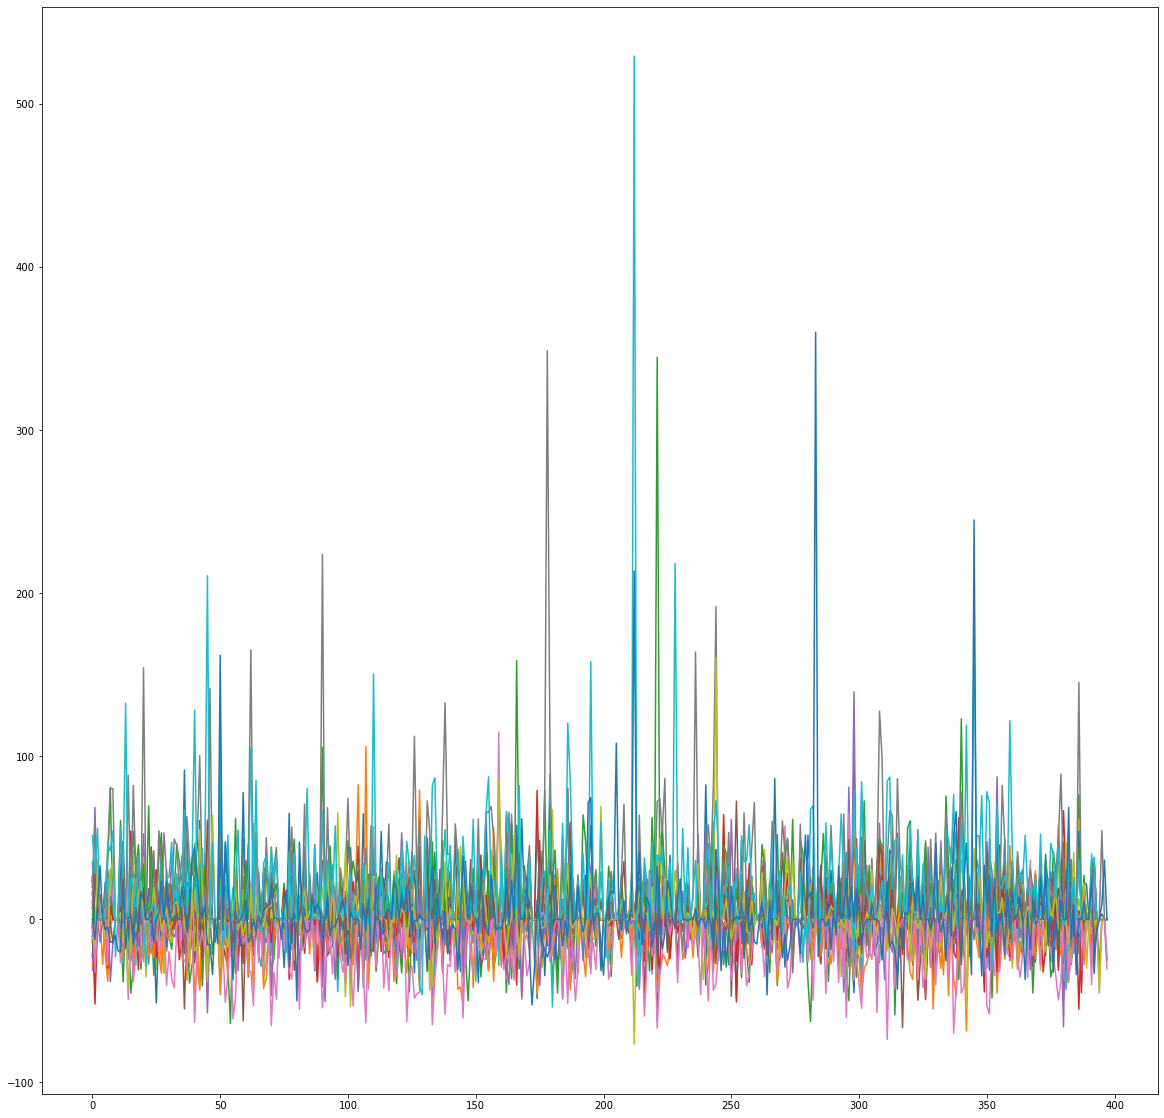

In [184]:
f = plt.figure(figsize=(20, 20))
plt.plot(y[:, 0, :])
plt.show()

In [185]:
pca_df = pd.read_parquet('final_df.parquet')
pca_df.head()

,Start Period,End Period,Ticker Code,Company Name,Share Price Return % (QTR),Market Cap,Daily Liquidity,Short Interest,RSI,Past 3M Return,...,"Price Volatility, 3","Price Volatility, 6",SMA 50,SMA 100,SMA 150,SMA 200,Avg 3 RSI,Avg 6 RSI,Avg 12 RSI,"Avg 3,6,12 RSI"
0,2010-12-31,2011-03-31,NYSE:ACN,Accenture plc,13.3600,31064,235.6,0,62.8,14.1,...,23.3234,21.2078,45.58,43.32,41.85,41.80,61.856576,57.874369,53.533407,57.754784
1,2010-12-31,2011-03-31,NasdaqGS:ADBE,Adobe Inc.,7.7300,15658,264.7,0,62.1,17.7,...,34.7297,44.9217,29.06,28.77,29.04,30.35,52.201444,50.265873,47.881376,50.116231
2,2010-12-31,2011-03-31,NasdaqGS:ADTN,"ADTRAN, Inc.",17.2604,2284,36.8,3,72.9,2.6,...,25.7520,28.4510,33.35,33.12,31.83,30.64,54.030546,57.427889,57.125619,56.194685
3,2010-12-31,2011-03-31,NasdaqGS:AKAM,"Akamai Technologies, Inc.",-19.2300,8579,241.7,1,37.2,-6.2,...,37.3781,40.8456,50.37,49.11,46.91,44.05,50.251298,53.641522,58.050712,53.981178
4,2010-12-31,2011-03-31,NYSE:ADS,Alliance Data Systems Corporation,20.9200,3693,57.2,5,66.6,8.8,...,26.2327,33.7621,65.49,63.72,63.21,64.82,56.501573,52.852267,52.903225,54.085688


In [186]:
pca_df.to_parquet('final_df.parquet')

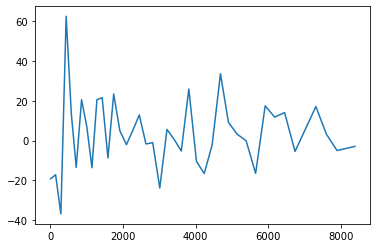

In [187]:
dd = pca_df[pca_df["Company Name"] == "Akamai Technologies, Inc."]["Share Price Return % (QTR)"]
plt.plot(dd)
plt.show()

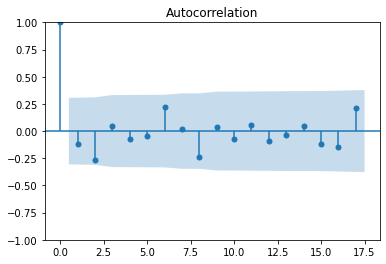

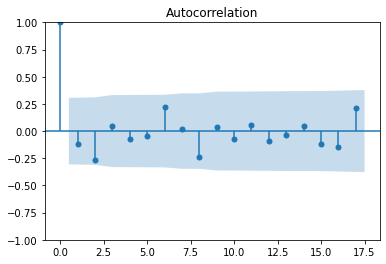

In [188]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dd) 

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


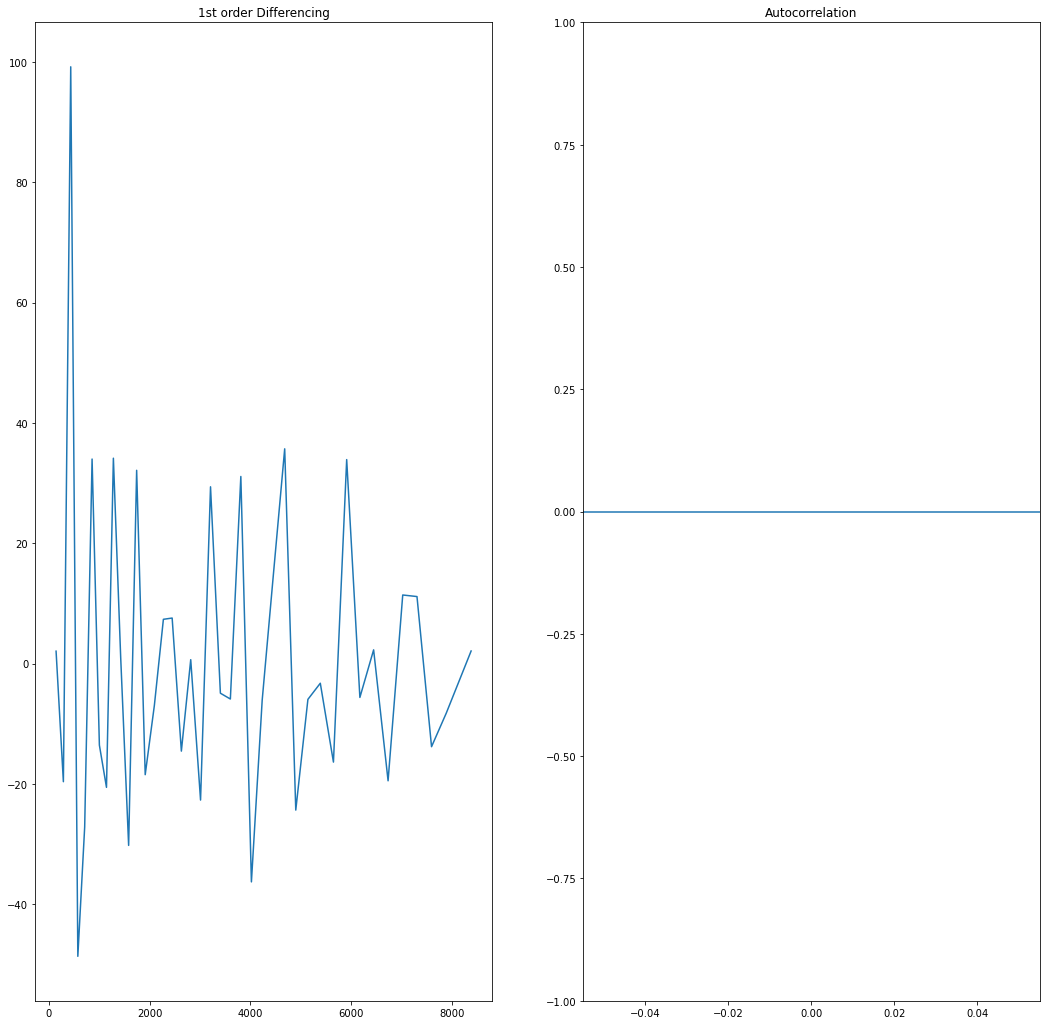

In [189]:
f = plt.figure(figsize=(18, 18))
ax1 = f.add_subplot(121)
ax1.set_title("1st order Differencing")
ax1.plot(dd.diff())

ax2 = f.add_subplot(122)
plot_acf(dd.diff(), ax=ax2)
plt.show()

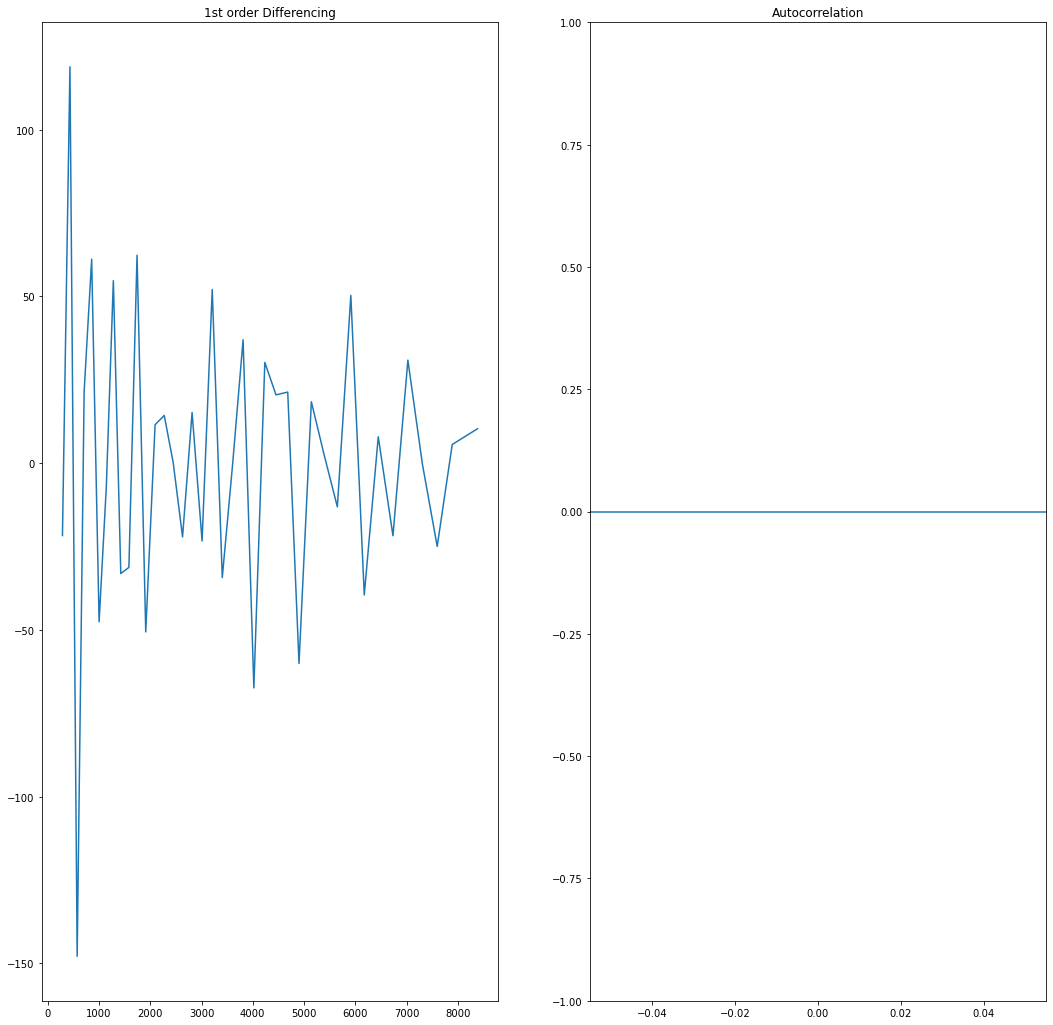

In [190]:
f = plt.figure(figsize=(18, 18))
ax1 = f.add_subplot(121)
ax1.set_title("1st order Differencing")
ax1.plot(dd.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(dd.diff().diff(), ax=ax2)
plt.show()

In [191]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(dd)
print("p-value: ", result[1])

result = adfuller(dd.diff().dropna())
print("p-value: ", result[1])

result = adfuller(dd.diff().diff().dropna())
print("p-value: ", result[1])

p-value:  4.940728711253309e-10
p-value:  9.315502386731869e-08
p-value:  2.583406936061313e-05


Based on the First and Second order differencing and the Autocorrelation plots, and the p-values of the Augmented Dickey Fuller test, it seems the optimal value for d is 1. As such, the ARIMA model(p, d, q) will be fit with parameters p=0, d=1, q=2. These parameters were empirically and theoretically tested for 12 different companies stock returns, and based on the Akaike Information Criterion and Bayesian information Crtierion, determined to be the best fit for ARIMA models for all companies.

In [192]:
arima_model = ARIMA(dd, order=(0, 1, 2))
model = arima_model.fit()
print(model.summary())

                                   SARIMAX Results                                    
Dep. Variable:     Share Price Return % (QTR)   No. Observations:                   41
Model:                         ARIMA(0, 1, 2)   Log Likelihood                -172.964
Date:                        Sat, 13 Aug 2022   AIC                            351.927
Time:                                08:37:17   BIC                            356.994
Sample:                                     0   HQIC                           353.759
                                         - 41                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2309     45.421     -0.027      0.978     -90.254      87.793
ma.L2          0.2311     10.453      0.022      0.982     -20.256 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [193]:
preds = model.predict()

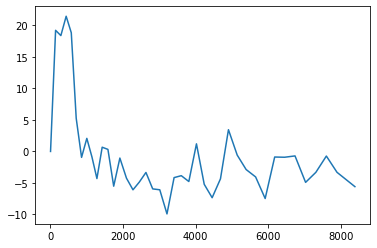

In [195]:
fig = plt.figure()
plt.plot(-preds)

The ARIMA model has predicted the conditional mean of the time series for Akamai Technologies, but to account for Heteroskedasticity of the stock returns, a GARCH model will also be fit on the ARIMA residuals to predict the
conditional variance of the stock returns time series, and the sum of the conditional mean from ARIMA, and conditional variance from GARCH, will form the final predictions of the 
model.

In [196]:
garch = arch.arch_model(preds-dd, p=1, q=2)
garch_fitted = garch.fit()

garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
prediction = preds + predicted_et

Iteration:      1,   Func. Count:      7,   Neg. LLF: 316.7291616580428
Iteration:      2,   Func. Count:     14,   Neg. LLF: 174.79393182421515
Iteration:      3,   Func. Count:     20,   Neg. LLF: 174.67472574723092
Iteration:      4,   Func. Count:     26,   Neg. LLF: 174.60232627444546
Iteration:      5,   Func. Count:     32,   Neg. LLF: 174.58374608055232
Iteration:      6,   Func. Count:     38,   Neg. LLF: 174.54933975488382
Iteration:      7,   Func. Count:     44,   Neg. LLF: 174.54689762528804
Iteration:      8,   Func. Count:     50,   Neg. LLF: 174.54462576567076
Iteration:      9,   Func. Count:     56,   Neg. LLF: 174.54062438323476
Iteration:     10,   Func. Count:     62,   Neg. LLF: 174.52827746292178
Iteration:     11,   Func. Count:     68,   Neg. LLF: 174.49864253435365
Iteration:     12,   Func. Count:     74,   Neg. LLF: 174.4222075704297
Iteration:     13,   Func. Count:     80,   Neg. LLF: 174.23542684382065
Iteration:     14,   Func. Count:     86,   Neg. LLF:

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [197]:
-prediction

3        1.344915
142     20.566180
287     19.730784
433     22.800732
574     20.183738
710      6.596841
857      0.404789
1002     3.421621
1143     0.471345
1280    -2.958606
1425     2.018201
1583     1.672129
1742    -4.167431
1912     0.295864
2094    -2.898935
2273    -4.741884
2447    -3.518490
2630    -1.987253
2816    -4.597334
3011    -4.738775
3209    -8.567839
3405    -2.805870
3603    -2.500817
3811    -3.426668
4021     2.552549
4235    -3.870082
4453    -5.994938
4682    -2.999227
4902     4.796055
5143     0.767493
5389    -1.527313
5650    -2.697535
5913    -6.125309
6175     0.461142
6448     0.425127
6735     0.635698
7026    -3.560719
7309    -1.966019
7598     0.614581
7891    -1.965827
8384    -4.240710
Name: predicted_mean, dtype: float64

In [198]:
dd

3      -19.2300
142    -17.1800
287    -36.8300
433     62.3700
574     13.6900
710    -13.4900
857     20.5000
1002     6.9300
1143   -13.6600
1280    20.4700
1425    21.5000
1583    -8.7400
1742    23.3786
1912     4.8961
2094    -2.0635
2273     5.2843
2447    12.8415
2630    -1.7243
2816    -1.0885
3011   -23.7909
3209     5.5862
3405     0.6478
3603    -5.2566
3811    25.8351
4021   -10.4700
4235   -16.5700
4453    -2.1900
4682    33.5000
4902     9.1300
5143     3.1700
5389    -0.1100
5650   -16.5000
5913    17.4000
6175    11.7600
6448    14.0300
6735    -5.4700
7026     5.9200
7309    17.0500
7598     3.2200
7891    -5.0200
8384    -2.9400
Name: Share Price Return % (QTR), dtype: float64

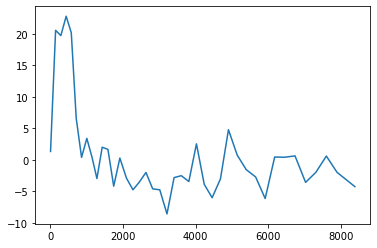

In [199]:
plt.plot(-prediction)

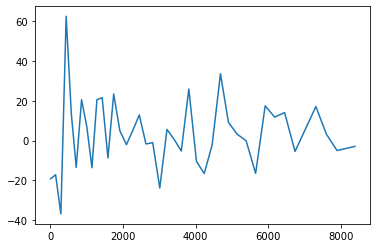

In [200]:
plt.plot(dd)

Only those companies that have a reported share price return in the required period will be included in the model. Further, as the lag parameter q of the ARIMA model is 2, any
company with less than or equal to 2 stock returns observations will also be dropped to maintain the configuration of the model.

In [201]:
selected_companies = pca_df[pca_df["Start Period"] == pca_df["Start Period"][pca_df.shape[0]-1]]["Company Name"]

In [202]:
selected_companies = list(selected_companies)

In [203]:
for company in selected_companies:
    if len(pca_df[pca_df["Company Name"] == company]["Share Price Return % (QTR)"]) <= 2:
        selected_companies.remove(company)

In [206]:
selected_companies = list(selected_companies)
selected_companies.remove("Cambium Networks Corporation")

In [207]:
company_returns = []

for company in selected_companies:
    print(company)
    dd = pca_df[pca_df["Company Name"] == company]["Share Price Return % (QTR)"]
    arima_model = ARIMA(dd.dropna(), order=(0, 1, 2))
    model = arima_model.fit()
    preds = model.predict()
    
    garch = arch.arch_model((preds-dd).dropna(), p=1, q=2)
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    predicted_et = garch_forecast.mean['h.1'].iloc[-1]
    prediction = preds + predicted_et
    company_returns.append(-prediction)

MicroVision, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 21.481397457463956
Iteration:      2,   Func. Count:     14,   Neg. LLF: 21.280537609844636
Iteration:      3,   Func. Count:     20,   Neg. LLF: 21.280473657458202
Iteration:      4,   Func. Count:     26,   Neg. LLF: 21.279980773567857
Iteration:      5,   Func. Count:     32,   Neg. LLF: 21.276484303235552
Iteration:      6,   Func. Count:     38,   Neg. LLF: 21.275541678284952
Iteration:      7,   Func. Count:     44,   Neg. LLF: 21.274926548917907
Iteration:      8,   Func. Count:     50,   Neg. LLF: 21.274925738670696
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21.274925738670696
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Riot Blockchain, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 21.309152240949526
Iteration:      2,   Func. Count:     14,   Neg. LLF: 21.172317287135122
Iteration:      3,   F

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 207.69315771901773
Iteration:      2,   Func. Count:     15,   Neg. LLF: 207.20605210986622
Iteration:      3,   Func. Count:     22,   Neg. LLF: 206.84088170159941
Iteration:      4,   Func. Count:     28,   Neg. LLF: 206.82939985839437
Iteration:      5,   Func. Count:     34,   Neg. LLF: 206.82826089648069
Iteration:      6,   Func. Count:     40,   Neg. LLF: 206.82723587176775
Iteration:      7,   Func. Count:     46,   Neg. LLF: 206.82460055430266
Iteration:      8,   Func. Count:     52,   Neg. LLF: 206.82196449019665
Iteration:      9,   Func. Count:     58,   Neg. LLF: 206.8203770777156
Iteration:     10,   Func. Count:     64,   Neg. LLF: 206.82006703168958
Iteration:     11,   Func. Count:     70,   Neg. LLF: 206.82005080489301
Iteration:     12,   Func. Count:     75,   Neg. LLF: 206.82005080487966
Optimization terminated successfully    (Exit mode 0)
            Current function value: 206.82005080489301
            Iter

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 180.33122718069774
Iteration:      2,   Func. Count:     15,   Neg. LLF: 184.9402171861023
Iteration:      3,   Func. Count:     23,   Neg. LLF: 179.55409910252604
Iteration:      4,   Func. Count:     29,   Neg. LLF: 179.51929781817626
Iteration:      5,   Func. Count:     35,   Neg. LLF: 179.3239930837952
Iteration:      6,   Func. Count:     41,   Neg. LLF: 181.30456126756403
Iteration:      7,   Func. Count:     48,   Neg. LLF: 179.39108902150338
Iteration:      8,   Func. Count:     55,   Neg. LLF: 179.0681994136689
Iteration:      9,   Func. Count:     61,   Neg. LLF: 179.03770037904593
Iteration:     10,   Func. Count:     67,   Neg. LLF: 179.00375496238667
Iteration:     11,   Func. Count:     73,   Neg. LLF: 178.9996627407457
Iteration:     12,   Func. Count:     79,   Neg. LLF: 178.99921255214394
Iteration:     13,   Func. Count:     85,   Neg. LLF: 178.99917748585872
Iteration:     14,   Func. Count:     91,   Neg. LLF: 1

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 221.6248393415157
Iteration:      2,   Func. Count:     14,   Neg. LLF: 177.13189349255427
Iteration:      3,   Func. Count:     20,   Neg. LLF: 177.0725837925593
Iteration:      4,   Func. Count:     26,   Neg. LLF: 176.95494187980754
Iteration:      5,   Func. Count:     32,   Neg. LLF: 176.9541655344591
Iteration:      6,   Func. Count:     38,   Neg. LLF: 176.95358063127506
Iteration:      7,   Func. Count:     44,   Neg. LLF: 176.9500350288798
Iteration:      8,   Func. Count:     50,   Neg. LLF: 176.94342043593176
Iteration:      9,   Func. Count:     56,   Neg. LLF: 176.92765773426723
Iteration:     10,   Func. Count:     62,   Neg. LLF: 176.89951291712816
Iteration:     11,   Func. Count:     68,   Neg. LLF: 176.8587242815928
Iteration:     12,   Func. Count:     74,   Neg. LLF: 176.81213740211712
Iteration:     13,   Func. Count:     80,   Neg. LLF: 176.76991877756188
Iteration:     14,   Func. Count:     86,   Neg. LLF: 17

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 67.72000641047448
Iteration:      2,   Func. Count:     15,   Neg. LLF: 60.31796431565583
Iteration:      3,   Func. Count:     21,   Neg. LLF: 60.31101619470993
Iteration:      4,   Func. Count:     27,   Neg. LLF: 60.27937505254076
Iteration:      5,   Func. Count:     33,   Neg. LLF: 60.27872801461107
Iteration:      6,   Func. Count:     39,   Neg. LLF: 60.27859448176821
Iteration:      7,   Func. Count:     45,   Neg. LLF: 60.27849442640782
Iteration:      8,   Func. Count:     51,   Neg. LLF: 60.278121033442886
Iteration:      9,   Func. Count:     57,   Neg. LLF: 60.27771425060627
Iteration:     10,   Func. Count:     63,   Neg. LLF: 60.27739805142257
Iteration:     11,   Func. Count:     69,   Neg. LLF: 60.27731772736218
Iteration:     12,   Func. Count:     75,   Neg. LLF: 60.27731090074328
Iteration:     13,   Func. Count:     80,   Neg. LLF: 60.27731090072818
Optimization terminated successfully    (Exit mode 0)
         

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      5,   Func. Count:     31,   Neg. LLF: 167.36797581601354
Iteration:      6,   Func. Count:     37,   Neg. LLF: 167.3668353706165
Iteration:      7,   Func. Count:     43,   Neg. LLF: 167.36653118101086
Iteration:      8,   Func. Count:     49,   Neg. LLF: 167.36456062071457
Iteration:      9,   Func. Count:     55,   Neg. LLF: 167.35701945402212
Iteration:     10,   Func. Count:     61,   Neg. LLF: 167.34318171696148
Iteration:     11,   Func. Count:     67,   Neg. LLF: 167.30327868759503
Iteration:     12,   Func. Count:     73,   Neg. LLF: 167.20635093199988
Iteration:     13,   Func. Count:     79,   Neg. LLF: 167.0713439036462
Iteration:     14,   Func. Count:     85,   Neg. LLF: 166.56443005877867
Iteration:     15,   Func. Count:     91,   Neg. LLF: 171.2685959706566
Iteration:     16,   Func. Count:     98,   Neg. LLF: 166.41617058158036
Iteration:     17,   Func. Count:    105,   Neg. LLF: 166.23382823568056
Iteration:     18,   Func. Count:    111,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      3,   Func. Count:     20,   Neg. LLF: 36.49089368436131
Iteration:      4,   Func. Count:     26,   Neg. LLF: 36.49058157559057
Iteration:      5,   Func. Count:     32,   Neg. LLF: 36.48847162885867
Iteration:      6,   Func. Count:     38,   Neg. LLF: 36.488071011006596
Iteration:      7,   Func. Count:     44,   Neg. LLF: 36.48806671003432
Iteration:      8,   Func. Count:     50,   Neg. LLF: 36.488056365824896
Iteration:      9,   Func. Count:     56,   Neg. LLF: 36.48803176198325
Iteration:     10,   Func. Count:     62,   Neg. LLF: 36.48800034151154
Iteration:     11,   Func. Count:     68,   Neg. LLF: 36.48797680251675
Iteration:     12,   Func. Count:     74,   Neg. LLF: 36.48797044743293
Iteration:     13,   Func. Count:     79,   Neg. LLF: 36.48797044738863
Optimization terminated successfully    (Exit mode 0)
            Current function value: 36.48797044743293
            Iterations: 13
            Function evaluations: 79
            Gradient evaluations: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 222.2313339033597
Iteration:      2,   Func. Count:     13,   Neg. LLF: 220.5220339678923
Iteration:      3,   Func. Count:     19,   Neg. LLF: 220.51727217751719
Iteration:      4,   Func. Count:     25,   Neg. LLF: 220.51545210174461
Iteration:      5,   Func. Count:     31,   Neg. LLF: 220.51358262337635
Iteration:      6,   Func. Count:     37,   Neg. LLF: 220.50698703750368
Iteration:      7,   Func. Count:     43,   Neg. LLF: 220.49672102167239
Iteration:      8,   Func. Count:     49,   Neg. LLF: 220.4842140627331
Iteration:      9,   Func. Count:     55,   Neg. LLF: 220.4781227883099
Iteration:     10,   Func. Count:     61,   Neg. LLF: 220.4769169022573
Iteration:     11,   Func. Count:     67,   Neg. LLF: 220.47677716945697
Iteration:     12,   Func. Count:     73,   Neg. LLF: 220.4767000498284
Iteration:     13,   Func. Count:     79,   Neg. LLF: 220.47640371497138
Iteration:     14,   Func. Count:     85,   Neg. LLF: 220

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      4,   Func. Count:     26,   Neg. LLF: 142.28290486750333
Iteration:      5,   Func. Count:     32,   Neg. LLF: 142.28049647442361
Iteration:      6,   Func. Count:     38,   Neg. LLF: 142.27967542221774
Iteration:      7,   Func. Count:     44,   Neg. LLF: 142.27904580168678
Iteration:      8,   Func. Count:     49,   Neg. LLF: 142.27904580172478
Optimization terminated successfully    (Exit mode 0)
            Current function value: 142.27904580168678
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Sanmina Corporation
Iteration:      1,   Func. Count:      7,   Neg. LLF: 314.2895600674268
Iteration:      2,   Func. Count:     15,   Neg. LLF: 175.34259352246977
Iteration:      3,   Func. Count:     21,   Neg. LLF: 175.27141759274156
Iteration:      4,   Func. Count:     27,   Neg. LLF: 175.02925731091406
Iteration:      5,   Func. Count:     33,   Neg. LLF: 174.93256165022186
Iteration:      6,   Func. Count:     39,  

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 320.4237282540335
Iteration:      2,   Func. Count:     15,   Neg. LLF: 182.1776862173594
Iteration:      3,   Func. Count:     21,   Neg. LLF: 182.1716633931352
Iteration:      4,   Func. Count:     27,   Neg. LLF: 182.17009472062963
Iteration:      5,   Func. Count:     33,   Neg. LLF: 182.16977979761367
Iteration:      6,   Func. Count:     39,   Neg. LLF: 182.169501660859
Iteration:      7,   Func. Count:     45,   Neg. LLF: 182.1678565828164
Iteration:      8,   Func. Count:     51,   Neg. LLF: 182.16296328985885
Iteration:      9,   Func. Count:     57,   Neg. LLF: 182.16131968053912
Iteration:     10,   Func. Count:     63,   Neg. LLF: 182.1553999893257
Iteration:     11,   Func. Count:     69,   Neg. LLF: 182.14460232932544
Iteration:     12,   Func. Count:     75,   Neg. LLF: 182.11318920275238
Iteration:     13,   Func. Count:     81,   Neg. LLF: 181.99596056881055
Iteration:     14,   Func. Count:     87,   Neg. LLF: 181.

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 111.5625419731515
Iteration:      2,   Func. Count:     15,   Neg. LLF: 108.19010294250529
Iteration:      3,   Func. Count:     21,   Neg. LLF: 108.19010161232084
Iteration:      4,   Func. Count:     27,   Neg. LLF: 108.19009996866636
Iteration:      5,   Func. Count:     33,   Neg. LLF: 108.19008907181015
Iteration:      6,   Func. Count:     39,   Neg. LLF: 108.19005530137079
Iteration:      7,   Func. Count:     45,   Neg. LLF: 108.18992687836199
Iteration:      8,   Func. Count:     51,   Neg. LLF: 108.18986844253081
Iteration:      9,   Func. Count:     57,   Neg. LLF: 108.18970346997415
Iteration:     10,   Func. Count:     63,   Neg. LLF: 108.18967527303148
Iteration:     11,   Func. Count:     68,   Neg. LLF: 108.1896752730685
Optimization terminated successfully    (Exit mode 0)
            Current function value: 108.18967527303148
            Iterations: 11
            Function evaluations: 68
            Gradient evalu

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:     29,   Func. Count:    175,   Neg. LLF: 99.20883319230518
Optimization terminated successfully    (Exit mode 0)
            Current function value: 99.20883317366984
            Iterations: 29
            Function evaluations: 175
            Gradient evaluations: 29
Stratasys Ltd.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 221.09826995844392
Iteration:      2,   Func. Count:     14,   Neg. LLF: 196.8522325884717
Iteration:      3,   Func. Count:     21,   Neg. LLF: 195.74083042712547
Iteration:      4,   Func. Count:     27,   Neg. LLF: 195.72847887517085
Iteration:      5,   Func. Count:     33,   Neg. LLF: 195.7186000232865
Iteration:      6,   Func. Count:     40,   Neg. LLF: 195.6938217616912
Iteration:      7,   Func. Count:     46,   Neg. LLF: 195.67538984198208
Iteration:      8,   Func. Count:     52,   Neg. LLF: 195.67432516469043
Iteration:      9,   Func. Count:     58,   Neg. LLF: 195.67430171605076
Iteration:     10,   Func. Count:     64,   Neg. 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 207.04660290163267
Iteration:      2,   Func. Count:     14,   Neg. LLF: 182.92833806325783
Iteration:      3,   Func. Count:     20,   Neg. LLF: 182.92470857264655
Iteration:      4,   Func. Count:     26,   Neg. LLF: 182.92367785271355
Iteration:      5,   Func. Count:     32,   Neg. LLF: 182.9227908895629
Iteration:      6,   Func. Count:     38,   Neg. LLF: 182.92207006805657
Iteration:      7,   Func. Count:     44,   Neg. LLF: 182.92166355091183
Iteration:      8,   Func. Count:     50,   Neg. LLF: 182.92141015413404
Iteration:      9,   Func. Count:     56,   Neg. LLF: 182.92132039710268
Iteration:     10,   Func. Count:     62,   Neg. LLF: 182.921246551086
Iteration:     11,   Func. Count:     68,   Neg. LLF: 182.9209071293415
Iteration:     12,   Func. Count:     74,   Neg. LLF: 182.92017067224128
Iteration:     13,   Func. Count:     80,   Neg. LLF: 182.9178965325976
Iteration:     14,   Func. Count:     86,   Neg. LLF: 18

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 186.52309081464918
Iteration:      2,   Func. Count:     13,   Neg. LLF: 185.5566509248534
Iteration:      3,   Func. Count:     19,   Neg. LLF: 185.78692623858555
Iteration:      4,   Func. Count:     26,   Neg. LLF: 185.42221446529373
Iteration:      5,   Func. Count:     32,   Neg. LLF: 185.33577138461445
Iteration:      6,   Func. Count:     38,   Neg. LLF: 185.31217247956886
Iteration:      7,   Func. Count:     44,   Neg. LLF: 185.31098873443236
Iteration:      8,   Func. Count:     50,   Neg. LLF: 185.31093335319724
Iteration:      9,   Func. Count:     56,   Neg. LLF: 185.31092323438097
Iteration:     10,   Func. Count:     62,   Neg. LLF: 185.31085705409234
Iteration:     11,   Func. Count:     68,   Neg. LLF: 185.31060331157397
Iteration:     12,   Func. Count:     74,   Neg. LLF: 185.3101452629349
Iteration:     13,   Func. Count:     80,   Neg. LLF: 185.30877167577063
Iteration:     14,   Func. Count:     86,   Neg. LLF:

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 133.9028563500733
Iteration:      2,   Func. Count:     14,   Neg. LLF: 124.50557622713586
Iteration:      3,   Func. Count:     21,   Neg. LLF: 123.5593758608758
Iteration:      4,   Func. Count:     27,   Neg. LLF: 123.501802467244
Iteration:      5,   Func. Count:     33,   Neg. LLF: 123.48131242169704
Iteration:      6,   Func. Count:     39,   Neg. LLF: 123.41436416234504
Iteration:      7,   Func. Count:     45,   Neg. LLF: 123.38470481701239
Iteration:      8,   Func. Count:     51,   Neg. LLF: 123.37180498963417
Iteration:      9,   Func. Count:     57,   Neg. LLF: 123.36267515294963
Iteration:     10,   Func. Count:     63,   Neg. LLF: 123.35964138057277
Iteration:     11,   Func. Count:     69,   Neg. LLF: 123.35944138902607
Iteration:     12,   Func. Count:     75,   Neg. LLF: 123.35939612072879
Iteration:     13,   Func. Count:     81,   Neg. LLF: 123.35930398901151
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 150.75761920989592
Iteration:      2,   Func. Count:     15,   Neg. LLF: 133.1700834002243
Iteration:      3,   Func. Count:     21,   Neg. LLF: 133.170048262348
Iteration:      4,   Func. Count:     27,   Neg. LLF: 133.17000810304881
Iteration:      5,   Func. Count:     33,   Neg. LLF: 133.1699254382467
Iteration:      6,   Func. Count:     39,   Neg. LLF: 133.16988703275993
Iteration:      7,   Func. Count:     45,   Neg. LLF: 133.16986044212453
Iteration:      8,   Func. Count:     51,   Neg. LLF: 133.16982583330588
Iteration:      9,   Func. Count:     57,   Neg. LLF: 133.16973824501744
Iteration:     10,   Func. Count:     63,   Neg. LLF: 133.1695904639006
Iteration:     11,   Func. Count:     69,   Neg. LLF: 133.16940176538273
Iteration:     12,   Func. Count:     75,   Neg. LLF: 133.1691809322972
Iteration:     13,   Func. Count:     81,   Neg. LLF: 133.16914214180736
Iteration:     14,   Func. Count:     87,   Neg. LLF: 133

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 143.70186656930304
Iteration:      2,   Func. Count:     14,   Neg. LLF: 142.2635947604296
Iteration:      3,   Func. Count:     21,   Neg. LLF: 142.22101586763128
Iteration:      4,   Func. Count:     27,   Neg. LLF: 142.20887568567207
Iteration:      5,   Func. Count:     33,   Neg. LLF: 142.20893815627232
Iteration:      6,   Func. Count:     40,   Neg. LLF: 142.20081294091517
Iteration:      7,   Func. Count:     46,   Neg. LLF: 142.19967369025528
Iteration:      8,   Func. Count:     52,   Neg. LLF: 142.19884735941426
Iteration:      9,   Func. Count:     58,   Neg. LLF: 142.19697194611848
Iteration:     10,   Func. Count:     64,   Neg. LLF: 142.19659962507876
Iteration:     11,   Func. Count:     70,   Neg. LLF: 142.1964322992724
Iteration:     12,   Func. Count:     76,   Neg. LLF: 142.1964310058874
Iteration:     13,   Func. Count:     81,   Neg. LLF: 142.19643100590267
Optimization terminated successfully    (Exit mode 0)


/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      8,   Func. Count:     50,   Neg. LLF: 54.40259750101416
Iteration:      9,   Func. Count:     55,   Neg. LLF: 54.402597501014775
Optimization terminated successfully    (Exit mode 0)
            Current function value: 54.40259750101416
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Dropbox, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 51.07972742114214
Iteration:      2,   Func. Count:     15,   Neg. LLF: 50.706316796641936
Iteration:      3,   Func. Count:     21,   Neg. LLF: 50.70631466425843
Iteration:      4,   Func. Count:     27,   Neg. LLF: 50.70630359074243
Iteration:      5,   Func. Count:     33,   Neg. LLF: 50.70623983290527
Iteration:      6,   Func. Count:     39,   Neg. LLF: 50.705676603180066
Iteration:      7,   Func. Count:     45,   Neg. LLF: 50.70538187849692
Iteration:      8,   Func. Count:     51,   Neg. LLF: 50.705379783356655
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_da

Iteration:      1,   Func. Count:      7,   Neg. LLF: 317.3304712533487
Iteration:      2,   Func. Count:     14,   Neg. LLF: 181.48091782514106
Iteration:      3,   Func. Count:     21,   Neg. LLF: 176.23223868864213
Iteration:      4,   Func. Count:     27,   Neg. LLF: 176.20991246868618
Iteration:      5,   Func. Count:     33,   Neg. LLF: 176.20127157563098
Iteration:      6,   Func. Count:     39,   Neg. LLF: 176.19646824556312
Iteration:      7,   Func. Count:     45,   Neg. LLF: 176.19605792567629
Iteration:      8,   Func. Count:     51,   Neg. LLF: 176.19579102802373
Iteration:      9,   Func. Count:     57,   Neg. LLF: 176.19479803887427
Iteration:     10,   Func. Count:     63,   Neg. LLF: 176.19370203472113
Iteration:     11,   Func. Count:     69,   Neg. LLF: 176.19174948592857
Iteration:     12,   Func. Count:     75,   Neg. LLF: 176.18837028178726
Iteration:     13,   Func. Count:     81,   Neg. LLF: 176.18088521082328
Iteration:     14,   Func. Count:     87,   Neg. LLF

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:     13,   Func. Count:     82,   Neg. LLF: 178.4899368887205
Iteration:     14,   Func. Count:     88,   Neg. LLF: 178.48985117164472
Iteration:     15,   Func. Count:     94,   Neg. LLF: 178.48964324509313
Iteration:     16,   Func. Count:    100,   Neg. LLF: 178.48910691191617
Iteration:     17,   Func. Count:    106,   Neg. LLF: 178.48778036431096
Iteration:     18,   Func. Count:    112,   Neg. LLF: 178.48470619005707
Iteration:     19,   Func. Count:    118,   Neg. LLF: 178.47936500609086
Iteration:     20,   Func. Count:    124,   Neg. LLF: 178.47321188931062
Iteration:     21,   Func. Count:    130,   Neg. LLF: 178.46989536252627
Iteration:     22,   Func. Count:    136,   Neg. LLF: 178.46937639122132
Iteration:     23,   Func. Count:    142,   Neg. LLF: 178.4693743821358
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.4693743821418
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.4693743821358
            Iterati

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:     17,   Func. Count:    105,   Neg. LLF: 153.21200838025342
Iteration:     18,   Func. Count:    111,   Neg. LLF: 153.21199283726878
Iteration:     19,   Func. Count:    117,   Neg. LLF: 153.21199230159397
Optimization terminated successfully    (Exit mode 0)
            Current function value: 153.21199230159397
            Iterations: 19
            Function evaluations: 117
            Gradient evaluations: 19
Plexus Corp.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 308.28082204615873
Iteration:      2,   Func. Count:     15,   Neg. LLF: 169.53941188328045
Iteration:      3,   Func. Count:     22,   Neg. LLF: 168.95360412486482
Iteration:      4,   Func. Count:     29,   Neg. LLF: 168.66663055173422
Iteration:      5,   Func. Count:     35,   Neg. LLF: 168.66126962805384
Iteration:      6,   Func. Count:     41,   Neg. LLF: 168.66051334996354
Iteration:      7,   Func. Count:     47,   Neg. LLF: 168.65987462598926
Iteration:      8,   Func. Count:     53,   Ne

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 203.834481022406
Iteration:      2,   Func. Count:     15,   Neg. LLF: 179.90880455733603
Iteration:      3,   Func. Count:     22,   Neg. LLF: 179.53907067678827
Iteration:      4,   Func. Count:     28,   Neg. LLF: 179.5339271217598
Iteration:      5,   Func. Count:     34,   Neg. LLF: 179.52879655044154
Iteration:      6,   Func. Count:     40,   Neg. LLF: 179.5274723665386
Iteration:      7,   Func. Count:     46,   Neg. LLF: 179.52542760876293
Iteration:      8,   Func. Count:     52,   Neg. LLF: 179.5251258466681
Iteration:      9,   Func. Count:     58,   Neg. LLF: 179.52509759037176
Iteration:     10,   Func. Count:     64,   Neg. LLF: 179.52509656833595
Iteration:     11,   Func. Count:     70,   Neg. LLF: 179.52509486470768
Iteration:     12,   Func. Count:     76,   Neg. LLF: 179.52509014985563
Iteration:     13,   Func. Count:     82,   Neg. LLF: 179.52507854101268
Iteration:     14,   Func. Count:     88,   Neg. LLF: 17

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      2,   Func. Count:     14,   Neg. LLF: 172.520037677805
Iteration:      3,   Func. Count:     20,   Neg. LLF: 172.51690449770413
Iteration:      4,   Func. Count:     26,   Neg. LLF: 172.51557652430938
Iteration:      5,   Func. Count:     32,   Neg. LLF: 172.51448493728373
Iteration:      6,   Func. Count:     38,   Neg. LLF: 172.51442707145117
Iteration:      7,   Func. Count:     44,   Neg. LLF: 172.51413614311895
Iteration:      8,   Func. Count:     50,   Neg. LLF: 172.5136467924515
Iteration:      9,   Func. Count:     56,   Neg. LLF: 172.51247223864064
Iteration:     10,   Func. Count:     62,   Neg. LLF: 172.50928794578735
Iteration:     11,   Func. Count:     68,   Neg. LLF: 172.50697534327753
Iteration:     12,   Func. Count:     74,   Neg. LLF: 172.50591349405096
Iteration:     13,   Func. Count:     80,   Neg. LLF: 172.50077622563055
Iteration:     14,   Func. Count:     86,   Neg. LLF: 172.47798851268215
Iteration:     15,   Func. Count:     92,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 176.33611908192256
Iteration:      2,   Func. Count:     14,   Neg. LLF: 157.82836011207266
Iteration:      3,   Func. Count:     21,   Neg. LLF: 154.2011883321939
Iteration:      4,   Func. Count:     27,   Neg. LLF: 154.15456075662573
Iteration:      5,   Func. Count:     33,   Neg. LLF: 154.20489530502368
Iteration:      6,   Func. Count:     40,   Neg. LLF: 154.13771457960667
Iteration:      7,   Func. Count:     46,   Neg. LLF: 154.13700783124602
Iteration:      8,   Func. Count:     52,   Neg. LLF: 154.13569564976854
Iteration:      9,   Func. Count:     58,   Neg. LLF: 154.1340322095343
Iteration:     10,   Func. Count:     64,   Neg. LLF: 154.1290380616207
Iteration:     11,   Func. Count:     70,   Neg. LLF: 154.11959012964965
Iteration:     12,   Func. Count:     76,   Neg. LLF: 154.10519441779695
Iteration:     13,   Func. Count:     82,   Neg. LLF: 154.09414672913476
Iteration:     14,   Func. Count:     88,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 167.27863903489333
Iteration:      2,   Func. Count:     15,   Neg. LLF: 164.8842267566332
Iteration:      3,   Func. Count:     22,   Neg. LLF: 163.21220853119723
Iteration:      4,   Func. Count:     28,   Neg. LLF: 163.20427203877688
Iteration:      5,   Func. Count:     34,   Neg. LLF: 163.2018111666189
Iteration:      6,   Func. Count:     40,   Neg. LLF: 163.20171593997443
Iteration:      7,   Func. Count:     46,   Neg. LLF: 163.2016344957086
Iteration:      8,   Func. Count:     52,   Neg. LLF: 163.20156579790944
Iteration:      9,   Func. Count:     58,   Neg. LLF: 163.20148820955316
Iteration:     10,   Func. Count:     64,   Neg. LLF: 163.20134262258262
Iteration:     11,   Func. Count:     70,   Neg. LLF: 163.20099531536385
Iteration:     12,   Func. Count:     76,   Neg. LLF: 163.20013610704896
Iteration:     13,   Func. Count:     82,   Neg. LLF: 163.19808434044683
Iteration:     14,   Func. Count:     88,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:     12,   Func. Count:     75,   Neg. LLF: 116.54084987786996
Iteration:     13,   Func. Count:     81,   Neg. LLF: 116.53958056920783
Iteration:     14,   Func. Count:     87,   Neg. LLF: 116.53752393380918
Iteration:     15,   Func. Count:     93,   Neg. LLF: 116.53363949107401
Iteration:     16,   Func. Count:     99,   Neg. LLF: 116.51995837977226
Iteration:     17,   Func. Count:    105,   Neg. LLF: 116.49783770042193
Iteration:     18,   Func. Count:    111,   Neg. LLF: 116.47672084832092
Iteration:     19,   Func. Count:    117,   Neg. LLF: 116.47282692217105
Iteration:     20,   Func. Count:    123,   Neg. LLF: 116.47209595711398
Iteration:     21,   Func. Count:    129,   Neg. LLF: 116.47162474883012
Iteration:     22,   Func. Count:    135,   Neg. LLF: 116.47139390264516
Iteration:     23,   Func. Count:    141,   Neg. LLF: 116.47125315354515
Iteration:     24,   Func. Count:    147,   Neg. LLF: 116.4709899648055
Iteration:     25,   Func. Count:    153,   Neg. LLF

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 180.3988431886069
Iteration:      2,   Func. Count:     15,   Neg. LLF: 159.21362092183458
Iteration:      3,   Func. Count:     21,   Neg. LLF: 159.1788572610301
Iteration:      4,   Func. Count:     27,   Neg. LLF: 159.17700082065573
Iteration:      5,   Func. Count:     33,   Neg. LLF: 159.1716194421555
Iteration:      6,   Func. Count:     39,   Neg. LLF: 159.17055472368364
Iteration:      7,   Func. Count:     45,   Neg. LLF: 159.1701175554394
Iteration:      8,   Func. Count:     51,   Neg. LLF: 159.16968893392027
Iteration:      9,   Func. Count:     57,   Neg. LLF: 159.1693929854584
Iteration:     10,   Func. Count:     63,   Neg. LLF: 159.16924852700134
Iteration:     11,   Func. Count:     69,   Neg. LLF: 159.1692162052448
Iteration:     12,   Func. Count:     75,   Neg. LLF: 159.16920721374714
Iteration:     13,   Func. Count:     81,   Neg. LLF: 159.1691919132221
Iteration:     14,   Func. Count:     87,   Neg. LLF: 159.

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Cantaloupe, Inc.
Iteration:      1,   Func. Count:     13,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 2
Wix.com Ltd.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 124.78257905985326
Iteration:      2,   Func. Count:     14,   Neg. LLF: 123.94244972373153
Iteration:      3,   Func. Count:     20,   Neg. LLF: 123.90649802530544
Iteration:      4,   Func. Count:     26,   Neg. LLF: 123.9042816350932
Iteration:      5,   Func. Count:     32,   Neg. LLF: 123.91269571202156
Iteration:      6,   Func. Count:     39,   Neg. LLF: 123.90376611673486
Iteration:      7,   Func. Count:     45,   Neg. LLF: 123.90375891442345
Iteration:      8,   Func. Count:     51,   Neg. LLF: 123.9037230119085
Iteration:      9,   Func. Count:     57,   Neg. LLF: 123.90356405746269
Iteration:     10,   Func. Count:     63,   Neg. LLF: 123.9031658

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      2,   Func. Count:     15,   Neg. LLF: 165.24887763425815
Iteration:      3,   Func. Count:     21,   Neg. LLF: 165.24764389664423
Iteration:      4,   Func. Count:     27,   Neg. LLF: 165.24732241840925
Iteration:      5,   Func. Count:     33,   Neg. LLF: 165.24715621798038
Iteration:      6,   Func. Count:     39,   Neg. LLF: 165.246948704861
Iteration:      7,   Func. Count:     45,   Neg. LLF: 165.24683158650467
Iteration:      8,   Func. Count:     51,   Neg. LLF: 165.24659253860645
Iteration:      9,   Func. Count:     57,   Neg. LLF: 165.24606062733133
Iteration:     10,   Func. Count:     63,   Neg. LLF: 165.2446318829657
Iteration:     11,   Func. Count:     69,   Neg. LLF: 165.24087216367934
Iteration:     12,   Func. Count:     75,   Neg. LLF: 165.23069210732717
Iteration:     13,   Func. Count:     81,   Neg. LLF: 165.19793815258384
Iteration:     14,   Func. Count:     87,   Neg. LLF: 165.07646644551812
Iteration:     15,   Func. Count:     93,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:     21,   Func. Count:    128,   Neg. LLF: 137.23843358215024
Optimization terminated successfully    (Exit mode 0)
            Current function value: 137.23843355982874
            Iterations: 21
            Function evaluations: 128
            Gradient evaluations: 21
Motorola Solutions, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 184.37849755107507
Iteration:      2,   Func. Count:     14,   Neg. LLF: 158.58519054491063
Iteration:      3,   Func. Count:     20,   Neg. LLF: 158.64751100971128
Iteration:      4,   Func. Count:     27,   Neg. LLF: 158.55819490486078
Iteration:      5,   Func. Count:     33,   Neg. LLF: 158.54644859290988
Iteration:      6,   Func. Count:     39,   Neg. LLF: 158.54641427634465
Iteration:      7,   Func. Count:     45,   Neg. LLF: 158.5462131052519
Iteration:      8,   Func. Count:     51,   Neg. LLF: 158.54578808754542
Iteration:      9,   Func. Count:     57,   Neg. LLF: 158.54464487074574
Iteration:     10,   Func. Count:  

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 204.60291033698547
Iteration:      2,   Func. Count:     14,   Neg. LLF: 182.57897596252778
Iteration:      3,   Func. Count:     20,   Neg. LLF: 182.45227633569826
Iteration:      4,   Func. Count:     26,   Neg. LLF: 182.37871738802133
Iteration:      5,   Func. Count:     32,   Neg. LLF: 182.37840320260742
Iteration:      6,   Func. Count:     38,   Neg. LLF: 182.37804034634502
Iteration:      7,   Func. Count:     44,   Neg. LLF: 182.3771777124367
Iteration:      8,   Func. Count:     50,   Neg. LLF: 182.37622176057636
Iteration:      9,   Func. Count:     56,   Neg. LLF: 182.375142784321
Iteration:     10,   Func. Count:     62,   Neg. LLF: 182.37386376931926
Iteration:     11,   Func. Count:     68,   Neg. LLF: 182.37139408441797
Iteration:     12,   Func. Count:     74,   Neg. LLF: 182.3655905433541
Iteration:     13,   Func. Count:     80,   Neg. LLF: 182.3515443331901
Iteration:     14,   Func. Count:     86,   Neg. LLF: 18

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 33.10809791512989
Iteration:      2,   Func. Count:     15,   Neg. LLF: 29.779157153077882
Iteration:      3,   Func. Count:     21,   Neg. LLF: 29.77914236531393
Iteration:      4,   Func. Count:     27,   Neg. LLF: 29.779056231890426
Iteration:      5,   Func. Count:     33,   Neg. LLF: 29.77871702331431
Iteration:      6,   Func. Count:     39,   Neg. LLF: 29.778559704268126
Iteration:      7,   Func. Count:     45,   Neg. LLF: 29.7785284174198
Iteration:      8,   Func. Count:     51,   Neg. LLF: 29.778527228470665
Iteration:      9,   Func. Count:     57,   Neg. LLF: 29.778525728007963
Iteration:     10,   Func. Count:     63,   Neg. LLF: 29.77852150158564
Iteration:     11,   Func. Count:     69,   Neg. LLF: 29.778512413461332
Iteration:     12,   Func. Count:     75,   Neg. LLF: 29.778495429829235
Iteration:     13,   Func. Count:     81,   Neg. LLF: 29.778476956267433
Iteration:     14,   Func. Count:     87,   Neg. LLF: 29.

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 189.28300728251074
Iteration:      2,   Func. Count:     15,   Neg. LLF: 165.20426066087683
Iteration:      3,   Func. Count:     22,   Neg. LLF: 164.61497132019514
Iteration:      4,   Func. Count:     28,   Neg. LLF: 164.60653360280554
Iteration:      5,   Func. Count:     34,   Neg. LLF: 164.6056968305609
Iteration:      6,   Func. Count:     40,   Neg. LLF: 164.60527344871474
Iteration:      7,   Func. Count:     46,   Neg. LLF: 164.6048365405678
Iteration:      8,   Func. Count:     52,   Neg. LLF: 164.60469570219564
Iteration:      9,   Func. Count:     58,   Neg. LLF: 164.60467280679018
Iteration:     10,   Func. Count:     64,   Neg. LLF: 164.6046648426086
Iteration:     11,   Func. Count:     70,   Neg. LLF: 164.60463895203043
Iteration:     12,   Func. Count:     76,   Neg. LLF: 164.60457942328037
Iteration:     13,   Func. Count:     82,   Neg. LLF: 164.60441691767318
Iteration:     14,   Func. Count:     88,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 318.47646223158563
Iteration:      2,   Func. Count:     15,   Neg. LLF: 180.74449373965032
Iteration:      3,   Func. Count:     21,   Neg. LLF: 180.74270890005508
Iteration:      4,   Func. Count:     27,   Neg. LLF: 180.73200548111478
Iteration:      5,   Func. Count:     33,   Neg. LLF: 180.6988516122287
Iteration:      6,   Func. Count:     39,   Neg. LLF: 180.6984739364414
Iteration:      7,   Func. Count:     45,   Neg. LLF: 180.6983110998473
Iteration:      8,   Func. Count:     51,   Neg. LLF: 180.69831104574297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 180.69831104574297
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Citrix Systems, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 300.08114976788823
Iteration:      2,   Func. Count:     15,   Neg. LLF: 160.98730801503672
Iteration:      3,   Func. Count:     22,   

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 68.65521582806457
Iteration:      2,   Func. Count:     15,   Neg. LLF: 61.304781753965486
Iteration:      3,   Func. Count:     21,   Neg. LLF: 61.304704471800356
Iteration:      4,   Func. Count:     27,   Neg. LLF: 61.304166876544954
Iteration:      5,   Func. Count:     33,   Neg. LLF: 61.29654945814427
Iteration:      6,   Func. Count:     39,   Neg. LLF: 61.29602791931331
Iteration:      7,   Func. Count:     45,   Neg. LLF: 61.29597153247251
Iteration:      8,   Func. Count:     51,   Neg. LLF: 61.29596993627646
Iteration:      9,   Func. Count:     57,   Neg. LLF: 61.29596222359032
Iteration:     10,   Func. Count:     63,   Neg. LLF: 61.295937456229915
Iteration:     11,   Func. Count:     69,   Neg. LLF: 61.2959290773185
Iteration:     12,   Func. Count:     74,   Neg. LLF: 61.29592907731778
Optimization terminated successfully    (Exit mode 0)
            Current function value: 61.2959290773185
            Iterations: 12

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 153.10270608570124
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147.43103217307305
Iteration:      3,   Func. Count:     21,   Neg. LLF: 148.13017820601735
Iteration:      4,   Func. Count:     28,   Neg. LLF: 147.02892921606963
Iteration:      5,   Func. Count:     35,   Neg. LLF: 147.00344504455373
Iteration:      6,   Func. Count:     41,   Neg. LLF: 147.00343419350418
Iteration:      7,   Func. Count:     47,   Neg. LLF: 147.0034322928875
Iteration:      8,   Func. Count:     53,   Neg. LLF: 147.00342003604771
Iteration:      9,   Func. Count:     59,   Neg. LLF: 147.00336496351792
Iteration:     10,   Func. Count:     65,   Neg. LLF: 147.00331863392302
Iteration:     11,   Func. Count:     71,   Neg. LLF: 147.00329176369712
Iteration:     12,   Func. Count:     77,   Neg. LLF: 147.0032850438654
Iteration:     13,   Func. Count:     82,   Neg. LLF: 147.00328504377615
Optimization terminated successfully    (Exit mode 0)

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 61.174716073006465
Iteration:      2,   Func. Count:     15,   Neg. LLF: 54.9412188620471
Iteration:      3,   Func. Count:     21,   Neg. LLF: 54.94047621091742
Iteration:      4,   Func. Count:     27,   Neg. LLF: 54.93658693830387
Iteration:      5,   Func. Count:     33,   Neg. LLF: 54.93352603021769
Iteration:      6,   Func. Count:     39,   Neg. LLF: 54.9335192627132
Iteration:      7,   Func. Count:     45,   Neg. LLF: 54.93350613670201
Iteration:      8,   Func. Count:     51,   Neg. LLF: 54.93348917639365
Iteration:      9,   Func. Count:     57,   Neg. LLF: 54.933441163185734
Iteration:     10,   Func. Count:     63,   Neg. LLF: 54.93337390366015
Iteration:     11,   Func. Count:     69,   Neg. LLF: 54.93331095735959
Iteration:     12,   Func. Count:     75,   Neg. LLF: 54.9332883916498
Iteration:     13,   Func. Count:     81,   Neg. LLF: 54.933285626022084
Iteration:     14,   Func. Count:     86,   Neg. LLF: 54.9332856

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 292.81495260164735
Iteration:      2,   Func. Count:     15,   Neg. LLF: 149.448024548844
Iteration:      3,   Func. Count:     21,   Neg. LLF: 149.41053912884934
Iteration:      4,   Func. Count:     27,   Neg. LLF: 149.40088170138299
Iteration:      5,   Func. Count:     33,   Neg. LLF: 149.39808491910904
Iteration:      6,   Func. Count:     39,   Neg. LLF: 149.38688483095888
Iteration:      7,   Func. Count:     45,   Neg. LLF: 149.37178458565023
Iteration:      8,   Func. Count:     51,   Neg. LLF: 149.35528342922223
Iteration:      9,   Func. Count:     57,   Neg. LLF: 149.3004514815022
Iteration:     10,   Func. Count:     63,   Neg. LLF: 149.18754802320638
Iteration:     11,   Func. Count:     69,   Neg. LLF: 149.11212099712927
Iteration:     12,   Func. Count:     75,   Neg. LLF: 149.1013878935444
Iteration:     13,   Func. Count:     81,   Neg. LLF: 149.10118376156538
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 152.06697392572067
Iteration:      2,   Func. Count:     14,   Neg. LLF: 147.28347977042645
Iteration:      3,   Func. Count:     20,   Neg. LLF: 147.26600821167224
Iteration:      4,   Func. Count:     26,   Neg. LLF: 147.24813452054514
Iteration:      5,   Func. Count:     32,   Neg. LLF: 147.24050419955387
Iteration:      6,   Func. Count:     38,   Neg. LLF: 147.22637594116208
Iteration:      7,   Func. Count:     44,   Neg. LLF: 147.219058371958
Iteration:      8,   Func. Count:     50,   Neg. LLF: 147.18693807305
Iteration:      9,   Func. Count:     56,   Neg. LLF: 147.17102199262203
Iteration:     10,   Func. Count:     62,   Neg. LLF: 147.16460157627318
Iteration:     11,   Func. Count:     68,   Neg. LLF: 147.16143872672333
Iteration:     12,   Func. Count:     74,   Neg. LLF: 147.14987288294813
Iteration:     13,   Func. Count:     80,   Neg. LLF: 147.10946303903685
Iteration:     14,   Func. Count:     86,   Neg. LLF: 14

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 148.76383145190854
Iteration:      2,   Func. Count:     15,   Neg. LLF: 132.2005320993359
Iteration:      3,   Func. Count:     21,   Neg. LLF: 132.18079854321556
Iteration:      4,   Func. Count:     27,   Neg. LLF: 132.180350308444
Iteration:      5,   Func. Count:     33,   Neg. LLF: 132.17842789941142
Iteration:      6,   Func. Count:     39,   Neg. LLF: 132.17664131710362
Iteration:      7,   Func. Count:     45,   Neg. LLF: 132.17546554210793
Iteration:      8,   Func. Count:     51,   Neg. LLF: 132.1749420507634
Iteration:      9,   Func. Count:     57,   Neg. LLF: 132.17484139670663
Iteration:     10,   Func. Count:     63,   Neg. LLF: 132.17479406647158
Iteration:     11,   Func. Count:     69,   Neg. LLF: 132.17467865925488
Iteration:     12,   Func. Count:     75,   Neg. LLF: 132.17457020165583
Iteration:     13,   Func. Count:     81,   Neg. LLF: 132.17451104835826
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 208.42051489077468
Iteration:      2,   Func. Count:     14,   Neg. LLF: 182.8780761005488
Iteration:      3,   Func. Count:     21,   Neg. LLF: 182.6585469534245
Iteration:      4,   Func. Count:     28,   Neg. LLF: 182.51568137984646
Iteration:      5,   Func. Count:     35,   Neg. LLF: 182.09136454781276
Iteration:      6,   Func. Count:     42,   Neg. LLF: 182.1157221919747
Iteration:      7,   Func. Count:     49,   Neg. LLF: 179.4876719963266
Iteration:      8,   Func. Count:     55,   Neg. LLF: 179.44241219048595
Iteration:      9,   Func. Count:     61,   Neg. LLF: 179.432769146123
Iteration:     10,   Func. Count:     68,   Neg. LLF: 179.32929835148883
Iteration:     11,   Func. Count:     74,   Neg. LLF: 179.26546857091023
Iteration:     12,   Func. Count:     80,   Neg. LLF: 179.210717912072
Iteration:     13,   Func. Count:     86,   Neg. LLF: 179.1313228202182
Iteration:     14,   Func. Count:     92,   Neg. LLF: 179.12

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 70.71428329000742
Iteration:      2,   Func. Count:     14,   Neg. LLF: 68.22016971346405
Iteration:      3,   Func. Count:     20,   Neg. LLF: 68.21605498001755
Iteration:      4,   Func. Count:     26,   Neg. LLF: 68.20085101507013
Iteration:      5,   Func. Count:     32,   Neg. LLF: 68.20047136055452
Iteration:      6,   Func. Count:     38,   Neg. LLF: 68.20032231933595
Iteration:      7,   Func. Count:     44,   Neg. LLF: 68.20029073061738
Iteration:      8,   Func. Count:     50,   Neg. LLF: 68.2002376678035
Iteration:      9,   Func. Count:     56,   Neg. LLF: 68.20021725125717
Iteration:     10,   Func. Count:     62,   Neg. LLF: 68.20017433088992
Iteration:     11,   Func. Count:     68,   Neg. LLF: 68.20010629731964
Iteration:     12,   Func. Count:     74,   Neg. LLF: 68.19998753962737
Iteration:     13,   Func. Count:     80,   Neg. LLF: 68.1998486462202
Iteration:     14,   Func. Count:     86,   Neg. LLF: 68.199707232

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 195.47696982734158
Iteration:      2,   Func. Count:     15,   Neg. LLF: 185.27917780818902
Iteration:      3,   Func. Count:     21,   Neg. LLF: 185.27875940431755
Iteration:      4,   Func. Count:     27,   Neg. LLF: 185.27759057896242
Iteration:      5,   Func. Count:     33,   Neg. LLF: 185.27581647668077
Iteration:      6,   Func. Count:     39,   Neg. LLF: 185.27119407635368
Iteration:      7,   Func. Count:     45,   Neg. LLF: 185.2696409891069
Iteration:      8,   Func. Count:     51,   Neg. LLF: 185.26821977377114
Iteration:      9,   Func. Count:     57,   Neg. LLF: 185.2678718806272
Iteration:     10,   Func. Count:     63,   Neg. LLF: 185.2664343630507
Iteration:     11,   Func. Count:     69,   Neg. LLF: 185.26598713491757
Iteration:     12,   Func. Count:     75,   Neg. LLF: 185.26596696351467
Iteration:     13,   Func. Count:     81,   Neg. LLF: 185.26596564724582
Iteration:     14,   Func. Count:     86,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 309.73603528901486
Iteration:      2,   Func. Count:     16,   Neg. LLF: 170.93646912117907
Iteration:      3,   Func. Count:     22,   Neg. LLF: 170.85668638301084
Iteration:      4,   Func. Count:     28,   Neg. LLF: 170.75201542396036
Iteration:      5,   Func. Count:     34,   Neg. LLF: 170.74797517973312
Iteration:      6,   Func. Count:     40,   Neg. LLF: 170.743595546425
Iteration:      7,   Func. Count:     46,   Neg. LLF: 170.7406436557274
Iteration:      8,   Func. Count:     52,   Neg. LLF: 170.74001937504593
Iteration:      9,   Func. Count:     58,   Neg. LLF: 170.73853786200812
Iteration:     10,   Func. Count:     64,   Neg. LLF: 170.73550376189448
Iteration:     11,   Func. Count:     70,   Neg. LLF: 170.7275190530057
Iteration:     12,   Func. Count:     76,   Neg. LLF: 170.71102971721868
Iteration:     13,   Func. Count:     82,   Neg. LLF: 170.68385477276448
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      9,   Func. Count:     58,   Neg. LLF: 136.8757543360164
Iteration:     10,   Func. Count:     64,   Neg. LLF: 136.87549702685266
Iteration:     11,   Func. Count:     70,   Neg. LLF: 136.8748529318075
Iteration:     12,   Func. Count:     76,   Neg. LLF: 136.87315880859356
Iteration:     13,   Func. Count:     82,   Neg. LLF: 136.86880750907542
Iteration:     14,   Func. Count:     88,   Neg. LLF: 136.85756186446017
Iteration:     15,   Func. Count:     94,   Neg. LLF: 136.82948961241178
Iteration:     16,   Func. Count:    100,   Neg. LLF: 136.76307814115836
Iteration:     17,   Func. Count:    106,   Neg. LLF: 136.70003019144102
Iteration:     18,   Func. Count:    112,   Neg. LLF: 136.68141192110315
Iteration:     19,   Func. Count:    118,   Neg. LLF: 136.67527988166256
Iteration:     20,   Func. Count:    124,   Neg. LLF: 136.6733392442683
Iteration:     21,   Func. Count:    130,   Neg. LLF: 136.67316887048375
Iteration:     22,   Func. Count:    136,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 163.67550063813007
Iteration:      2,   Func. Count:     15,   Neg. LLF: 157.35580393299566
Iteration:      3,   Func. Count:     21,   Neg. LLF: 157.3527708426999
Iteration:      4,   Func. Count:     27,   Neg. LLF: 157.3494212499632
Iteration:      5,   Func. Count:     33,   Neg. LLF: 157.34931594419294
Iteration:      6,   Func. Count:     39,   Neg. LLF: 157.34925846711678
Iteration:      7,   Func. Count:     45,   Neg. LLF: 157.34925035434824
Iteration:      8,   Func. Count:     51,   Neg. LLF: 157.34924807233602
Iteration:      9,   Func. Count:     56,   Neg. LLF: 157.3492480723139
Optimization terminated successfully    (Exit mode 0)
            Current function value: 157.34924807233602
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
QIWI plc
Iteration:      1,   Func. Count:      7,   Neg. LLF: 132.04135852371442
Iteration:      2,   Func. Count:     13,   Neg. LLF: 13

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 192.99391112996358
Iteration:      2,   Func. Count:     14,   Neg. LLF: 168.78376240528323
Iteration:      3,   Func. Count:     20,   Neg. LLF: 168.7818532058165
Iteration:      4,   Func. Count:     26,   Neg. LLF: 168.7766507260586
Iteration:      5,   Func. Count:     32,   Neg. LLF: 168.7757950066345
Iteration:      6,   Func. Count:     38,   Neg. LLF: 168.77560351769125
Iteration:      7,   Func. Count:     44,   Neg. LLF: 168.77489636507946
Iteration:      8,   Func. Count:     50,   Neg. LLF: 168.77442182252798
Iteration:      9,   Func. Count:     56,   Neg. LLF: 168.77292655445518
Iteration:     10,   Func. Count:     62,   Neg. LLF: 168.76969085594328
Iteration:     11,   Func. Count:     68,   Neg. LLF: 168.76076522099743
Iteration:     12,   Func. Count:     74,   Neg. LLF: 168.73855842097805
Iteration:     13,   Func. Count:     80,   Neg. LLF: 168.68116370950116
Iteration:     14,   Func. Count:     86,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:     20,   Func. Count:    124,   Neg. LLF: 178.3886830475153
Iteration:     21,   Func. Count:    130,   Neg. LLF: 178.31756927099786
Iteration:     22,   Func. Count:    136,   Neg. LLF: 178.1529536612912
Iteration:     23,   Func. Count:    142,   Neg. LLF: 178.04828210092933
Iteration:     24,   Func. Count:    148,   Neg. LLF: 178.02919917732694
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.01113492019343
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.01068809744126
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.01062863982938
Iteration:     28,   Func. Count:    171,   Neg. LLF: 178.0106286398294
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.01062863982938
            Iterations: 28
            Function evaluations: 171
            Gradient evaluations: 28
NetScout Systems, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 204.8363605457964
Iteration:      2,   Func. Count:     14

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:     11,   Func. Count:     69,   Neg. LLF: 166.8123962958392
Iteration:     12,   Func. Count:     75,   Neg. LLF: 166.81104350850833
Iteration:     13,   Func. Count:     81,   Neg. LLF: 166.806560405591
Iteration:     14,   Func. Count:     87,   Neg. LLF: 166.79620803918473
Iteration:     15,   Func. Count:     93,   Neg. LLF: 166.77093017202978
Iteration:     16,   Func. Count:     99,   Neg. LLF: 166.72459730225734
Iteration:     17,   Func. Count:    105,   Neg. LLF: 166.67754055551845
Iteration:     18,   Func. Count:    111,   Neg. LLF: 166.67404389659748
Iteration:     19,   Func. Count:    117,   Neg. LLF: 166.67358862196656
Iteration:     20,   Func. Count:    123,   Neg. LLF: 166.67280520957453
Iteration:     21,   Func. Count:    129,   Neg. LLF: 166.67132140631512
Iteration:     22,   Func. Count:    135,   Neg. LLF: 166.66833547391911
Iteration:     23,   Func. Count:    141,   Neg. LLF: 166.66829859964028
Iteration:     24,   Func. Count:    147,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 175.6682503260461
Iteration:      2,   Func. Count:     14,   Neg. LLF: 174.52679870810474
Iteration:      3,   Func. Count:     20,   Neg. LLF: 174.46726745336332
Iteration:      4,   Func. Count:     26,   Neg. LLF: 174.25565653152108
Iteration:      5,   Func. Count:     32,   Neg. LLF: 174.20098699616787
Iteration:      6,   Func. Count:     38,   Neg. LLF: 174.1830798077632
Iteration:      7,   Func. Count:     44,   Neg. LLF: 174.17844355218992
Iteration:      8,   Func. Count:     50,   Neg. LLF: 174.1768578079474
Iteration:      9,   Func. Count:     56,   Neg. LLF: 174.1767349483446
Iteration:     10,   Func. Count:     62,   Neg. LLF: 174.17667977293306
Iteration:     11,   Func. Count:     68,   Neg. LLF: 174.17652891345912
Iteration:     12,   Func. Count:     74,   Neg. LLF: 174.1761552515645
Iteration:     13,   Func. Count:     80,   Neg. LLF: 174.17524565079643
Iteration:     14,   Func. Count:     86,   Neg. LLF: 17

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 190.56352946953078
Iteration:      2,   Func. Count:     14,   Neg. LLF: 178.22722769242208
Iteration:      3,   Func. Count:     20,   Neg. LLF: 178.19523323175645
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.0562710877439
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.03425652811717
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.03137790520248
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.0310879320634
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.03101843469753
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.03092710193295
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.03088166797147
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.0308497547723
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.03080574929706
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.03069373413985
Iteration:     14,   Func. Count:     87,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/arch/univariate/volatility.py:1189: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,

Iteration:      1,   Func. Count:      7,   Neg. LLF: 150.05769306929358
Iteration:      2,   Func. Count:     15,   Neg. LLF: 149.9378582455283
Iteration:      3,   Func. Count:     22,   Neg. LLF: 149.57882603852985
Iteration:      4,   Func. Count:     28,   Neg. LLF: 149.55778512015593
Iteration:      5,   Func. Count:     34,   Neg. LLF: 149.55647552662484
Iteration:      6,   Func. Count:     40,   Neg. LLF: 149.55618512590226
Iteration:      7,   Func. Count:     46,   Neg. LLF: 149.55613206575993
Iteration:      8,   Func. Count:     52,   Neg. LLF: 149.55578817084876
Iteration:      9,   Func. Count:     58,   Neg. LLF: 149.55388857316765
Iteration:     10,   Func. Count:     64,   Neg. LLF: 149.54777803712153
Iteration:     11,   Func. Count:     70,   Neg. LLF: 149.54110848084267
Iteration:     12,   Func. Count:     76,   Neg. LLF: 149.53133459425248
Iteration:     13,   Func. Count:     82,   Neg. LLF: 149.52079800931463
Iteration:     14,   Func. Count:     88,   Neg. LLF

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 89.56475712857424
Iteration:      2,   Func. Count:     14,   Neg. LLF: 88.15730333158743
Iteration:      3,   Func. Count:     20,   Neg. LLF: 88.12048660809337
Iteration:      4,   Func. Count:     26,   Neg. LLF: 88.10320591124326
Iteration:      5,   Func. Count:     32,   Neg. LLF: 88.08001775037934
Iteration:      6,   Func. Count:     38,   Neg. LLF: 88.07269612880852
Iteration:      7,   Func. Count:     44,   Neg. LLF: 88.06315925737051
Iteration:      8,   Func. Count:     50,   Neg. LLF: 88.05408069462307
Iteration:      9,   Func. Count:     56,   Neg. LLF: 88.04921866446679
Iteration:     10,   Func. Count:     62,   Neg. LLF: 88.04893884209511
Iteration:     11,   Func. Count:     68,   Neg. LLF: 88.04892197188641
Iteration:     12,   Func. Count:     73,   Neg. LLF: 88.04892197188843
Optimization terminated successfully    (Exit mode 0)
            Current function value: 88.04892197188641
            Iterations: 12
 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False.

Iteration:      1,   Func. Count:      7,   Neg. LLF: 110.03375990682089
Iteration:      2,   Func. Count:     14,   Neg. LLF: 109.10947145166446
Iteration:      3,   Func. Count:     20,   Neg. LLF: 109.02587912217138
Iteration:      4,   Func. Count:     26,   Neg. LLF: 108.87218398241157
Iteration:      5,   Func. Count:     32,   Neg. LLF: 108.85879652055083
Iteration:      6,   Func. Count:     38,   Neg. LLF: 108.84983307679298
Iteration:      7,   Func. Count:     44,   Neg. LLF: 108.8478558788042
Iteration:      8,   Func. Count:     50,   Neg. LLF: 108.84774254438882
Iteration:      9,   Func. Count:     56,   Neg. LLF: 108.847604084993
Iteration:     10,   Func. Count:     62,   Neg. LLF: 108.84727558476186
Iteration:     11,   Func. Count:     68,   Neg. LLF: 108.84641557193746
Iteration:     12,   Func. Count:     74,   Neg. LLF: 108.84425020559694
Iteration:     13,   Func. Count:     80,   Neg. LLF: 108.83901468714417
Iteration:     14,   Func. Count:     86,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 158.76531889938792
Iteration:      2,   Func. Count:     15,   Neg. LLF: 152.25725175440172
Iteration:      3,   Func. Count:     21,   Neg. LLF: 152.18695967505838
Iteration:      4,   Func. Count:     27,   Neg. LLF: 152.17978219980913
Iteration:      5,   Func. Count:     33,   Neg. LLF: 152.17949472733574
Iteration:      6,   Func. Count:     39,   Neg. LLF: 152.17922585970237
Iteration:      7,   Func. Count:     45,   Neg. LLF: 152.1791502640018
Iteration:      8,   Func. Count:     51,   Neg. LLF: 152.1791263845768
Iteration:      9,   Func. Count:     57,   Neg. LLF: 152.17911796722743
Iteration:     10,   Func. Count:     63,   Neg. LLF: 152.17909287827257
Iteration:     11,   Func. Count:     69,   Neg. LLF: 152.17903542868785
Iteration:     12,   Func. Count:     75,   Neg. LLF: 152.178876061554
Iteration:     13,   Func. Count:     81,   Neg. LLF: 152.17846425521867
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      9,   Func. Count:     57,   Neg. LLF: 164.65015441714314
Iteration:     10,   Func. Count:     63,   Neg. LLF: 164.64703191566832
Iteration:     11,   Func. Count:     69,   Neg. LLF: 164.63609647287026
Iteration:     12,   Func. Count:     75,   Neg. LLF: 164.63314668792754
Iteration:     13,   Func. Count:     81,   Neg. LLF: 164.6318528838965
Iteration:     14,   Func. Count:     87,   Neg. LLF: 164.63111078233368
Iteration:     15,   Func. Count:     93,   Neg. LLF: 164.6302693241331
Iteration:     16,   Func. Count:     99,   Neg. LLF: 164.63025459578012
Iteration:     17,   Func. Count:    104,   Neg. LLF: 164.63025459580496
Optimization terminated successfully    (Exit mode 0)
            Current function value: 164.63025459578012
            Iterations: 17
            Function evaluations: 104
            Gradient evaluations: 17
Nuance Communications, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 172.61851949911883
Iteration:      2,   Func. Count:

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 105.36806188750683
Iteration:      2,   Func. Count:     14,   Neg. LLF: 103.80678723283398
Iteration:      3,   Func. Count:     20,   Neg. LLF: 103.79596913259601
Iteration:      4,   Func. Count:     26,   Neg. LLF: 103.78177599319534
Iteration:      5,   Func. Count:     32,   Neg. LLF: 103.78154925994073
Iteration:      6,   Func. Count:     38,   Neg. LLF: 103.78118940182658
Iteration:      7,   Func. Count:     44,   Neg. LLF: 103.7811120303918
Iteration:      8,   Func. Count:     50,   Neg. LLF: 103.7806517491031
Iteration:      9,   Func. Count:     56,   Neg. LLF: 103.77885279756136
Iteration:     10,   Func. Count:     62,   Neg. LLF: 103.77747127164899
Iteration:     11,   Func. Count:     68,   Neg. LLF: 103.77602886926566
Iteration:     12,   Func. Count:     74,   Neg. LLF: 103.77147031810105
Iteration:     13,   Func. Count:     80,   Neg. LLF: 103.76052529575553
Iteration:     14,   Func. Count:     86,   Neg. LLF:

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 191.03143627292795
Iteration:      2,   Func. Count:     15,   Neg. LLF: 168.42674879407588
Iteration:      3,   Func. Count:     21,   Neg. LLF: 168.42629350615522
Iteration:      4,   Func. Count:     27,   Neg. LLF: 168.42413243165004
Iteration:      5,   Func. Count:     33,   Neg. LLF: 168.40867121733638
Iteration:      6,   Func. Count:     39,   Neg. LLF: 168.40756239401287
Iteration:      7,   Func. Count:     45,   Neg. LLF: 168.40749844450062
Iteration:      8,   Func. Count:     51,   Neg. LLF: 168.4074807220952
Iteration:      9,   Func. Count:     57,   Neg. LLF: 168.407455442992
Iteration:     10,   Func. Count:     63,   Neg. LLF: 168.40745264406192
Iteration:     11,   Func. Count:     68,   Neg. LLF: 168.40745264394897
Optimization terminated successfully    (Exit mode 0)
            Current function value: 168.40745264406192
            Iterations: 11
            Function evaluations: 68
            Gradient evalua

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 35.22521030825235
Iteration:      2,   Func. Count:     14,   Neg. LLF: 31.244120959973205
Iteration:      3,   Func. Count:     20,   Neg. LLF: 31.240526687309178
Iteration:      4,   Func. Count:     26,   Neg. LLF: 31.2132281289475
Iteration:      5,   Func. Count:     32,   Neg. LLF: 31.20843832906045
Iteration:      6,   Func. Count:     38,   Neg. LLF: 31.205697700185212
Iteration:      7,   Func. Count:     44,   Neg. LLF: 31.205569754000834
Iteration:      8,   Func. Count:     50,   Neg. LLF: 31.204923254810154
Iteration:      9,   Func. Count:     56,   Neg. LLF: 31.202863125469833
Iteration:     10,   Func. Count:     62,   Neg. LLF: 31.202215431535148
Iteration:     11,   Func. Count:     67,   Neg. LLF: 31.20221543149612
Optimization terminated successfully    (Exit mode 0)
            Current function value: 31.202215431535148
            Iterations: 11
            Function evaluations: 67
            Gradient evaluati

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 36.5296199337987
Iteration:      2,   Func. Count:     14,   Neg. LLF: 36.06128162489293
Iteration:      3,   Func. Count:     20,   Neg. LLF: 36.06073576675777
Iteration:      4,   Func. Count:     26,   Neg. LLF: 36.0595960963355
Iteration:      5,   Func. Count:     32,   Neg. LLF: 36.0444255988442
Iteration:      6,   Func. Count:     38,   Neg. LLF: 36.042135285123614
Iteration:      7,   Func. Count:     44,   Neg. LLF: 36.04097563214903
Iteration:      8,   Func. Count:     50,   Neg. LLF: 36.04092205588603
Iteration:      9,   Func. Count:     56,   Neg. LLF: 36.0406236666419
Iteration:     10,   Func. Count:     62,   Neg. LLF: 36.039657426865745
Iteration:     11,   Func. Count:     68,   Neg. LLF: 36.03941355526529
Iteration:     12,   Func. Count:     74,   Neg. LLF: 36.03941230010436
Iteration:     13,   Func. Count:     79,   Neg. LLF: 36.03941230012479
Optimization terminated successfully    (Exit mode 0)
            

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 158.83011840210895
Iteration:      2,   Func. Count:     15,   Neg. LLF: 143.49802035259
Iteration:      3,   Func. Count:     21,   Neg. LLF: 143.49797962067277
Iteration:      4,   Func. Count:     27,   Neg. LLF: 143.4979696558313
Iteration:      5,   Func. Count:     33,   Neg. LLF: 143.49796446363248
Iteration:      6,   Func. Count:     39,   Neg. LLF: 143.49792683185015
Iteration:      7,   Func. Count:     45,   Neg. LLF: 143.49779052073558
Iteration:      8,   Func. Count:     51,   Neg. LLF: 143.4974081672268
Iteration:      9,   Func. Count:     57,   Neg. LLF: 143.4973289625439
Iteration:     10,   Func. Count:     63,   Neg. LLF: 143.49720306345375
Iteration:     11,   Func. Count:     68,   Neg. LLF: 143.49720306348075
Optimization terminated successfully    (Exit mode 0)
            Current function value: 143.49720306345375
            Iterations: 11
            Function evaluations: 68
            Gradient evaluatio

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      4,   Func. Count:     27,   Neg. LLF: 100.8016120603997
Iteration:      5,   Func. Count:     33,   Neg. LLF: 100.80153618741244
Iteration:      6,   Func. Count:     39,   Neg. LLF: 100.80151370637344
Iteration:      7,   Func. Count:     45,   Neg. LLF: 100.80147390639948
Iteration:      8,   Func. Count:     51,   Neg. LLF: 100.80141249454414
Iteration:      9,   Func. Count:     57,   Neg. LLF: 100.80136449422879
Iteration:     10,   Func. Count:     63,   Neg. LLF: 100.80134830495759
Iteration:     11,   Func. Count:     69,   Neg. LLF: 100.80134583840895
Iteration:     12,   Func. Count:     75,   Neg. LLF: 100.8013447593757
Iteration:     13,   Func. Count:     81,   Neg. LLF: 100.80134144542147
Iteration:     14,   Func. Count:     87,   Neg. LLF: 100.80133369666827
Iteration:     15,   Func. Count:     93,   Neg. LLF: 100.80131194876012
Iteration:     16,   Func. Count:     99,   Neg. LLF: 100.80125682547356
Iteration:     17,   Func. Count:    105,   Neg. LLF:

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 145.58518876989845
Iteration:      2,   Func. Count:     14,   Neg. LLF: 142.40823250085785
Iteration:      3,   Func. Count:     20,   Neg. LLF: 142.40561568225124
Iteration:      4,   Func. Count:     26,   Neg. LLF: 142.39853987679126
Iteration:      5,   Func. Count:     32,   Neg. LLF: 142.39831973772792
Iteration:      6,   Func. Count:     38,   Neg. LLF: 142.39822520430621
Iteration:      7,   Func. Count:     44,   Neg. LLF: 142.39800007238588
Iteration:      8,   Func. Count:     50,   Neg. LLF: 142.39797462561606
Iteration:      9,   Func. Count:     56,   Neg. LLF: 142.39782240956836
Iteration:     10,   Func. Count:     62,   Neg. LLF: 142.39713295885213
Iteration:     11,   Func. Count:     68,   Neg. LLF: 142.39557991512524
Iteration:     12,   Func. Count:     74,   Neg. LLF: 142.3955419520824
Iteration:     13,   Func. Count:     80,   Neg. LLF: 142.39534894682137
Iteration:     14,   Func. Count:     86,   Neg. LLF

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 123.30484841557764
Iteration:      2,   Func. Count:     14,   Neg. LLF: 109.29679112093179
Iteration:      3,   Func. Count:     20,   Neg. LLF: 109.2614859115894
Iteration:      4,   Func. Count:     26,   Neg. LLF: 109.25731838433322
Iteration:      5,   Func. Count:     32,   Neg. LLF: 109.23459243944701
Iteration:      6,   Func. Count:     38,   Neg. LLF: 109.20731335883875
Iteration:      7,   Func. Count:     44,   Neg. LLF: 109.20690869620466
Iteration:      8,   Func. Count:     50,   Neg. LLF: 109.20685145051479
Iteration:      9,   Func. Count:     56,   Neg. LLF: 109.20684721191967
Iteration:     10,   Func. Count:     62,   Neg. LLF: 109.20682277731682
Iteration:     11,   Func. Count:     68,   Neg. LLF: 109.20676768071877
Iteration:     12,   Func. Count:     74,   Neg. LLF: 109.2067521879288
Iteration:     13,   Func. Count:     80,   Neg. LLF: 109.20673683304578
Iteration:     14,   Func. Count:     86,   Neg. LLF:

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 39.08577818572909
Iteration:      2,   Func. Count:     14,   Neg. LLF: 38.62387457399276
Iteration:      3,   Func. Count:     20,   Neg. LLF: 38.62385187264637
Iteration:      4,   Func. Count:     26,   Neg. LLF: 38.6236935647539
Iteration:      5,   Func. Count:     32,   Neg. LLF: 38.62208306297651
Iteration:      6,   Func. Count:     38,   Neg. LLF: 38.61936337832072
Iteration:      7,   Func. Count:     44,   Neg. LLF: 38.619270028101
Iteration:      8,   Func. Count:     50,   Neg. LLF: 38.61926484054976
Iteration:      9,   Func. Count:     55,   Neg. LLF: 38.61926484055025
Optimization terminated successfully    (Exit mode 0)
            Current function value: 38.61926484054976
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
salesforce.com, inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 168.35125312445166
Iteration:      2,   Func. Count:     13,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:     13,   Func. Count:     81,   Neg. LLF: 169.37736362145552
Iteration:     14,   Func. Count:     87,   Neg. LLF: 169.3583911257422
Iteration:     15,   Func. Count:     93,   Neg. LLF: 169.3422592033277
Iteration:     16,   Func. Count:     99,   Neg. LLF: 169.33047452932126
Iteration:     17,   Func. Count:    105,   Neg. LLF: 169.3286233474051
Iteration:     18,   Func. Count:    111,   Neg. LLF: 169.3285984789077
Iteration:     19,   Func. Count:    116,   Neg. LLF: 169.3285985398689
Optimization terminated successfully    (Exit mode 0)
            Current function value: 169.3285984789077
            Iterations: 19
            Function evaluations: 116
            Gradient evaluations: 19
Adobe Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 174.1500308107419
Iteration:      2,   Func. Count:     14,   Neg. LLF: 160.27898780069935
Iteration:      3,   Func. Count:     21,   Neg. LLF: 158.60633636237802
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 18.541229356625543
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18.455498688143855
Iteration:      3,   Func. Count:     20,   Neg. LLF: 18.45483310075324
Iteration:      4,   Func. Count:     26,   Neg. LLF: 18.452486545486412
Iteration:      5,   Func. Count:     32,   Neg. LLF: 18.4495156349996
Iteration:      6,   Func. Count:     38,   Neg. LLF: 18.447871987141184
Iteration:      7,   Func. Count:     44,   Neg. LLF: 18.447730392290275
Iteration:      8,   Func. Count:     49,   Neg. LLF: 18.44773039269904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 18.447730392290275
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
IPG Photonics Corporation
Iteration:      1,   Func. Count:      7,   Neg. LLF: 334.6299121548507
Iteration:      2,   Func. Count:     14,   Neg. LLF: 189.06492813502857
Iteration:      3,   Func. Count:     20,

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 170.04249084332244
Iteration:      2,   Func. Count:     14,   Neg. LLF: 167.6915748631431
Iteration:      3,   Func. Count:     20,   Neg. LLF: 167.68560087804968
Iteration:      4,   Func. Count:     26,   Neg. LLF: 167.6853017062736
Iteration:      5,   Func. Count:     32,   Neg. LLF: 167.68455113078673
Iteration:      6,   Func. Count:     38,   Neg. LLF: 167.68319845014676
Iteration:      7,   Func. Count:     44,   Neg. LLF: 167.68141494625164
Iteration:      8,   Func. Count:     50,   Neg. LLF: 167.68010208309082
Iteration:      9,   Func. Count:     56,   Neg. LLF: 167.67941588811547
Iteration:     10,   Func. Count:     62,   Neg. LLF: 167.67874217709527
Iteration:     11,   Func. Count:     68,   Neg. LLF: 167.67724316273484
Iteration:     12,   Func. Count:     74,   Neg. LLF: 167.67347758131874
Iteration:     13,   Func. Count:     80,   Neg. LLF: 167.66360014059842
Iteration:     14,   Func. Count:     86,   Neg. LLF:

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      8,   Func. Count:     51,   Neg. LLF: 150.2001877862202
Iteration:      9,   Func. Count:     57,   Neg. LLF: 150.19769299011296
Iteration:     10,   Func. Count:     63,   Neg. LLF: 150.19087002365055
Iteration:     11,   Func. Count:     69,   Neg. LLF: 150.17141455600571
Iteration:     12,   Func. Count:     75,   Neg. LLF: 150.1220994848078
Iteration:     13,   Func. Count:     81,   Neg. LLF: 150.08530242529537
Iteration:     14,   Func. Count:     87,   Neg. LLF: 149.99417021609563
Iteration:     15,   Func. Count:     93,   Neg. LLF: 149.98144656957533
Iteration:     16,   Func. Count:     99,   Neg. LLF: 149.9758027636826
Iteration:     17,   Func. Count:    105,   Neg. LLF: 149.97553002304753
Iteration:     18,   Func. Count:    111,   Neg. LLF: 149.97542749395535
Iteration:     19,   Func. Count:    116,   Neg. LLF: 149.9754274940175
Optimization terminated successfully    (Exit mode 0)
            Current function value: 149.97542749395535
            Iterati

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 186.74333317982467
Iteration:      2,   Func. Count:     15,   Neg. LLF: 163.02044194938222
Iteration:      3,   Func. Count:     22,   Neg. LLF: 162.73939361089418
Iteration:      4,   Func. Count:     28,   Neg. LLF: 162.73202816734508
Iteration:      5,   Func. Count:     34,   Neg. LLF: 162.73136518335403
Iteration:      6,   Func. Count:     40,   Neg. LLF: 162.73084662192045
Iteration:      7,   Func. Count:     46,   Neg. LLF: 162.73029706910296
Iteration:      8,   Func. Count:     52,   Neg. LLF: 162.72977171081268
Iteration:      9,   Func. Count:     58,   Neg. LLF: 162.72916834357596
Iteration:     10,   Func. Count:     64,   Neg. LLF: 162.72810828691715
Iteration:     11,   Func. Count:     70,   Neg. LLF: 162.72559870207084
Iteration:     12,   Func. Count:     76,   Neg. LLF: 162.71927402335538
Iteration:     13,   Func. Count:     82,   Neg. LLF: 162.70296428323377
Iteration:     14,   Func. Count:     88,   Neg. LL

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 127.06407475573917
Iteration:      2,   Func. Count:     15,   Neg. LLF: 121.37125333239592
Iteration:      3,   Func. Count:     20,   Neg. LLF: 121.37125333234779
Optimization terminated successfully    (Exit mode 0)
            Current function value: 121.37125333239592
            Iterations: 3
            Function evaluations: 20
            Gradient evaluations: 3
Cloudflare, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 28.920389742154065
Iteration:      2,   Func. Count:     15,   Neg. LLF: 28.60222360182148
Iteration:      3,   Func. Count:     21,   Neg. LLF: 28.60216926659986
Iteration:      4,   Func. Count:     27,   Neg. LLF: 28.602068585085973
Iteration:      5,   Func. Count:     33,   Neg. LLF: 28.601367605972975
Iteration:      6,   Func. Count:     39,   Neg. LLF: 28.60029081848553
Iteration:      7,   Func. Count:     45,   Neg. LLF: 28.600275961523796
Iteration:      8,   Func. Count:     51,   Neg.

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 175.48025002366703
Iteration:      2,   Func. Count:     15,   Neg. LLF: 176.2156606216877
Iteration:      3,   Func. Count:     23,   Neg. LLF: 173.40680508232225
Iteration:      4,   Func. Count:     29,   Neg. LLF: 173.40345027867914
Iteration:      5,   Func. Count:     35,   Neg. LLF: 173.39567385621092
Iteration:      6,   Func. Count:     41,   Neg. LLF: 173.3953803537648
Iteration:      7,   Func. Count:     47,   Neg. LLF: 173.39534476163968
Iteration:      8,   Func. Count:     53,   Neg. LLF: 173.3953434337152
Iteration:      9,   Func. Count:     58,   Neg. LLF: 173.3953434336955
Optimization terminated successfully    (Exit mode 0)
            Current function value: 173.3953434337152
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
Infinera Corporation
Iteration:      1,   Func. Count:      7,   Neg. LLF: 198.6419285877011
Iteration:      2,   Func. Count:     15,   Neg

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:     19,   Func. Count:    119,   Neg. LLF: 160.13086726648558
Iteration:     20,   Func. Count:    125,   Neg. LLF: 160.1307520584877
Iteration:     21,   Func. Count:    131,   Neg. LLF: 160.1307413079728
Iteration:     22,   Func. Count:    137,   Neg. LLF: 160.13073945997772
Iteration:     23,   Func. Count:    142,   Neg. LLF: 160.13073945980952
Optimization terminated successfully    (Exit mode 0)
            Current function value: 160.13073945997772
            Iterations: 23
            Function evaluations: 142
            Gradient evaluations: 23
SPS Commerce, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 142.1016259621428
Iteration:      2,   Func. Count:     14,   Neg. LLF: 133.69893288730842
Iteration:      3,   Func. Count:     20,   Neg. LLF: 133.69726909216737
Iteration:      4,   Func. Count:     26,   Neg. LLF: 133.68863853468014
Iteration:      5,   Func. Count:     32,   Neg. LLF: 133.68738570674768
Iteration:      6,   Func. Count:     38,  

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 163.00661434911058
Iteration:      2,   Func. Count:     14,   Neg. LLF: 151.8469243736208
Iteration:      3,   Func. Count:     20,   Neg. LLF: 151.83183878022624
Iteration:      4,   Func. Count:     26,   Neg. LLF: 151.8231591525259
Iteration:      5,   Func. Count:     32,   Neg. LLF: 151.8220856025561
Iteration:      6,   Func. Count:     38,   Neg. LLF: 151.8208526787996
Iteration:      7,   Func. Count:     44,   Neg. LLF: 151.82008318488562
Iteration:      8,   Func. Count:     50,   Neg. LLF: 151.81976210700182
Iteration:      9,   Func. Count:     56,   Neg. LLF: 151.81963427109937
Iteration:     10,   Func. Count:     62,   Neg. LLF: 151.81939469099692
Iteration:     11,   Func. Count:     68,   Neg. LLF: 151.8187827442873
Iteration:     12,   Func. Count:     74,   Neg. LLF: 151.81716755682248
Iteration:     13,   Func. Count:     80,   Neg. LLF: 151.81294424879087
Iteration:     14,   Func. Count:     86,   Neg. LLF: 15

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 91.80274383102214
Iteration:      2,   Func. Count:     15,   Neg. LLF: 91.27230009155006
Iteration:      3,   Func. Count:     21,   Neg. LLF: 91.27229371773468
Iteration:      4,   Func. Count:     27,   Neg. LLF: 91.272278787666
Iteration:      5,   Func. Count:     33,   Neg. LLF: 91.2722054622474
Iteration:      6,   Func. Count:     39,   Neg. LLF: 91.27191537130946
Iteration:      7,   Func. Count:     45,   Neg. LLF: 91.27177701577679
Iteration:      8,   Func. Count:     51,   Neg. LLF: 91.27160245853044
Iteration:      9,   Func. Count:     57,   Neg. LLF: 91.2715451791879
Iteration:     10,   Func. Count:     62,   Neg. LLF: 91.2715451791905
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.2715451791879
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
II-VI Incorporated
Iteration:      1,   Func. Count:      7,   Neg. LLF: 183.

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      7,   Func. Count:     45,   Neg. LLF: 81.34046301830038
Iteration:      8,   Func. Count:     51,   Neg. LLF: 81.34011838724415
Iteration:      9,   Func. Count:     57,   Neg. LLF: 81.34009844419367
Iteration:     10,   Func. Count:     62,   Neg. LLF: 81.34009844867528
Optimization terminated successfully    (Exit mode 0)
            Current function value: 81.34009844419367
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Limelight Networks, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 59.54565765014633
Iteration:      2,   Func. Count:     14,   Neg. LLF: 53.16345158721842
Iteration:      3,   Func. Count:     20,   Neg. LLF: 53.114720315687656
Iteration:      4,   Func. Count:     26,   Neg. LLF: 53.097137764438585
Iteration:      5,   Func. Count:     32,   Neg. LLF: 53.097046621609444
Iteration:      6,   Func. Count:     38,   Neg. LLF: 53.09693378132715
Iteration:      7,   Func. Count:     44,  

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 49.71462504979824
Iteration:      2,   Func. Count:     14,   Neg. LLF: 45.174211893897265
Iteration:      3,   Func. Count:     20,   Neg. LLF: 45.173977363423305
Iteration:      4,   Func. Count:     26,   Neg. LLF: 45.17264070348286
Iteration:      5,   Func. Count:     32,   Neg. LLF: 45.16712754111182
Iteration:      6,   Func. Count:     38,   Neg. LLF: 45.167120365921775
Iteration:      7,   Func. Count:     44,   Neg. LLF: 45.1671156228631
Iteration:      8,   Func. Count:     50,   Neg. LLF: 45.167108018295096
Iteration:      9,   Func. Count:     56,   Neg. LLF: 45.16708403210793
Iteration:     10,   Func. Count:     62,   Neg. LLF: 45.167030525411974
Iteration:     11,   Func. Count:     68,   Neg. LLF: 45.16691249169887
Iteration:     12,   Func. Count:     74,   Neg. LLF: 45.166723224675835
Iteration:     13,   Func. Count:     80,   Neg. LLF: 45.16654541830071
Iteration:     14,   Func. Count:     86,   Neg. LLF: 45.16

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 76.35248220551665
Iteration:      2,   Func. Count:     14,   Neg. LLF: 73.99756926261017
Iteration:      3,   Func. Count:     20,   Neg. LLF: 73.99760982197698
Iteration:      4,   Func. Count:     27,   Neg. LLF: 73.9973589055717
Iteration:      5,   Func. Count:     33,   Neg. LLF: 73.99723776155432
Iteration:      6,   Func. Count:     39,   Neg. LLF: 73.99675382524333
Iteration:      7,   Func. Count:     45,   Neg. LLF: 73.99647330360898
Iteration:      8,   Func. Count:     51,   Neg. LLF: 73.99638959884604
Iteration:      9,   Func. Count:     57,   Neg. LLF: 73.99638361383823
Iteration:     10,   Func. Count:     62,   Neg. LLF: 73.99638361383714
Optimization terminated successfully    (Exit mode 0)
            Current function value: 73.99638361383823
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Zix Corporation
Iteration:      1,   Func. Count:      7,   Neg. LLF: 38

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 71.17042945129457
Iteration:      2,   Func. Count:     14,   Neg. LLF: 69.77406770172935
Iteration:      3,   Func. Count:     20,   Neg. LLF: 69.76762786999086
Iteration:      4,   Func. Count:     26,   Neg. LLF: 69.76528950088971
Iteration:      5,   Func. Count:     32,   Neg. LLF: 69.76521077850282
Iteration:      6,   Func. Count:     38,   Neg. LLF: 69.76511047026658
Iteration:      7,   Func. Count:     44,   Neg. LLF: 69.76493055284139
Iteration:      8,   Func. Count:     50,   Neg. LLF: 69.76476339476021
Iteration:      9,   Func. Count:     56,   Neg. LLF: 69.76468905385528
Iteration:     10,   Func. Count:     62,   Neg. LLF: 69.76467847240285
Iteration:     11,   Func. Count:     67,   Neg. LLF: 69.76467847908826
Optimization terminated successfully    (Exit mode 0)
            Current function value: 69.76467847240285
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 222.34004340863603
Iteration:      2,   Func. Count:     15,   Neg. LLF: 124.63846118666827
Iteration:      3,   Func. Count:     21,   Neg. LLF: 124.61010375309965
Iteration:      4,   Func. Count:     27,   Neg. LLF: 124.58745343564485
Iteration:      5,   Func. Count:     33,   Neg. LLF: 124.57404179430391
Iteration:      6,   Func. Count:     39,   Neg. LLF: 124.57352120080816
Iteration:      7,   Func. Count:     45,   Neg. LLF: 124.57333097619525
Iteration:      8,   Func. Count:     51,   Neg. LLF: 124.57298015603357
Iteration:      9,   Func. Count:     57,   Neg. LLF: 124.57272881012399
Iteration:     10,   Func. Count:     63,   Neg. LLF: 124.5725440251076
Iteration:     11,   Func. Count:     69,   Neg. LLF: 124.57243805969318
Iteration:     12,   Func. Count:     75,   Neg. LLF: 124.57227136479526
Iteration:     13,   Func. Count:     81,   Neg. LLF: 124.5718718405739
Iteration:     14,   Func. Count:     87,   Neg. LLF:

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 167.55745658171006
Iteration:      2,   Func. Count:     15,   Neg. LLF: 148.28275271699255
Iteration:      3,   Func. Count:     21,   Neg. LLF: 148.28259921135833
Iteration:      4,   Func. Count:     27,   Neg. LLF: 148.28250584329268
Iteration:      5,   Func. Count:     33,   Neg. LLF: 148.28197872344492
Iteration:      6,   Func. Count:     39,   Neg. LLF: 148.280492978382
Iteration:      7,   Func. Count:     45,   Neg. LLF: 148.2803514296549
Iteration:      8,   Func. Count:     51,   Neg. LLF: 148.28031183930364
Iteration:      9,   Func. Count:     57,   Neg. LLF: 148.28023014483648
Iteration:     10,   Func. Count:     63,   Neg. LLF: 148.28019824939042
Iteration:     11,   Func. Count:     69,   Neg. LLF: 148.2801820077099
Iteration:     12,   Func. Count:     75,   Neg. LLF: 148.2801801983967
Iteration:     13,   Func. Count:     80,   Neg. LLF: 148.28018019836622
Optimization terminated successfully    (Exit mode 0)
  

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 46.48387088455928
Iteration:      2,   Func. Count:     14,   Neg. LLF: 45.979045573896386
Iteration:      3,   Func. Count:     20,   Neg. LLF: 45.978542349923316
Iteration:      4,   Func. Count:     26,   Neg. LLF: 45.97546366535581
Iteration:      5,   Func. Count:     32,   Neg. LLF: 45.96403889579234
Iteration:      6,   Func. Count:     38,   Neg. LLF: 45.963331930494576
Iteration:      7,   Func. Count:     44,   Neg. LLF: 45.96249081043661
Iteration:      8,   Func. Count:     50,   Neg. LLF: 45.96248519914307
Iteration:      9,   Func. Count:     56,   Neg. LLF: 45.962451019243034
Iteration:     10,   Func. Count:     62,   Neg. LLF: 45.962275196776645
Iteration:     11,   Func. Count:     68,   Neg. LLF: 45.96151739401952
Iteration:     12,   Func. Count:     74,   Neg. LLF: 45.960245967745756
Iteration:     13,   Func. Count:     80,   Neg. LLF: 45.96024305948927
Iteration:     14,   Func. Count:     85,   Neg. LLF: 45.9

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 54.308941657586765
Iteration:      2,   Func. Count:     14,   Neg. LLF: 52.67687411212748
Iteration:      3,   Func. Count:     20,   Neg. LLF: 52.676696246494814
Iteration:      4,   Func. Count:     26,   Neg. LLF: 52.67556411846052
Iteration:      5,   Func. Count:     32,   Neg. LLF: 52.66869054479753
Iteration:      6,   Func. Count:     38,   Neg. LLF: 52.66854065034499
Iteration:      7,   Func. Count:     44,   Neg. LLF: 52.66849795526807
Iteration:      8,   Func. Count:     50,   Neg. LLF: 52.668466380207974
Iteration:      9,   Func. Count:     56,   Neg. LLF: 52.66840014706129
Iteration:     10,   Func. Count:     62,   Neg. LLF: 52.66836875180852
Iteration:     11,   Func. Count:     68,   Neg. LLF: 52.668360817013166
Iteration:     12,   Func. Count:     74,   Neg. LLF: 52.66836003318656
Optimization terminated successfully    (Exit mode 0)
            Current function value: 52.66836003318656
            Iterations: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 84.03625038521488
Iteration:      2,   Func. Count:     15,   Neg. LLF: 83.40853340006944
Iteration:      3,   Func. Count:     21,   Neg. LLF: 83.40847272121637
Iteration:      4,   Func. Count:     27,   Neg. LLF: 83.40794164221808
Iteration:      5,   Func. Count:     33,   Neg. LLF: 83.40583393908847
Iteration:      6,   Func. Count:     39,   Neg. LLF: 83.40562557859786
Iteration:      7,   Func. Count:     45,   Neg. LLF: 83.40557863501465
Iteration:      8,   Func. Count:     50,   Neg. LLF: 83.405578635016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 83.40557863501465
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Rapid7, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 96.10290383779926
Iteration:      2,   Func. Count:     15,   Neg. LLF: 85.84815628893442
Iteration:      3,   Func. Count:     21,   Neg. LLF: 85.84812

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 103.73532496584298
Iteration:      2,   Func. Count:     14,   Neg. LLF: 102.9662818873374
Iteration:      3,   Func. Count:     20,   Neg. LLF: 102.96767165492531
Iteration:      4,   Func. Count:     27,   Neg. LLF: 102.96599912943407
Iteration:      5,   Func. Count:     34,   Neg. LLF: 102.94785231368758
Iteration:      6,   Func. Count:     40,   Neg. LLF: 102.94698009805673
Iteration:      7,   Func. Count:     46,   Neg. LLF: 102.94609774418592
Iteration:      8,   Func. Count:     52,   Neg. LLF: 102.94358336583845
Iteration:      9,   Func. Count:     58,   Neg. LLF: 102.94326222441897
Iteration:     10,   Func. Count:     64,   Neg. LLF: 102.94316881102091
Iteration:     11,   Func. Count:     70,   Neg. LLF: 102.94292962992691
Iteration:     12,   Func. Count:     76,   Neg. LLF: 102.94244085291928
Iteration:     13,   Func. Count:     82,   Neg. LLF: 102.94082065517597
Iteration:     14,   Func. Count:     88,   Neg. LLF

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 79.47642545959008
Iteration:      2,   Func. Count:     14,   Neg. LLF: 76.9739409209851
Iteration:      3,   Func. Count:     20,   Neg. LLF: 76.9451636353681
Iteration:      4,   Func. Count:     26,   Neg. LLF: 76.94640897980966
Iteration:      5,   Func. Count:     33,   Neg. LLF: 76.94015943003612
Iteration:      6,   Func. Count:     39,   Neg. LLF: 76.93928655673159
Iteration:      7,   Func. Count:     45,   Neg. LLF: 76.93873929539498
Iteration:      8,   Func. Count:     51,   Neg. LLF: 76.93716604227819
Iteration:      9,   Func. Count:     57,   Neg. LLF: 76.93643926993703
Iteration:     10,   Func. Count:     63,   Neg. LLF: 76.93621674321662
Iteration:     11,   Func. Count:     69,   Neg. LLF: 76.9361895805091
Iteration:     12,   Func. Count:     75,   Neg. LLF: 76.93616330566458
Iteration:     13,   Func. Count:     81,   Neg. LLF: 76.93608530060864
Iteration:     14,   Func. Count:     87,   Neg. LLF: 76.9358930828

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 30.31508379826439
Iteration:      2,   Func. Count:     14,   Neg. LLF: 29.939856298718865
Iteration:      3,   Func. Count:     20,   Neg. LLF: 29.93984856870972
Iteration:      4,   Func. Count:     26,   Neg. LLF: 29.939799663101574
Iteration:      5,   Func. Count:     32,   Neg. LLF: 29.939405818327472
Iteration:      6,   Func. Count:     38,   Neg. LLF: 29.93552638270941
Iteration:      7,   Func. Count:     44,   Neg. LLF: 29.933842830230745
Iteration:      8,   Func. Count:     50,   Neg. LLF: 29.932056272669293
Iteration:      9,   Func. Count:     56,   Neg. LLF: 29.932051436621386
Iteration:     10,   Func. Count:     62,   Neg. LLF: 29.93204632522083
Iteration:     11,   Func. Count:     68,   Neg. LLF: 29.93202831327867
Iteration:     12,   Func. Count:     74,   Neg. LLF: 29.931991919666693
Iteration:     13,   Func. Count:     80,   Neg. LLF: 29.931921365751165
Iteration:     14,   Func. Count:     86,   Neg. LLF: 29

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 175.23686542301598
Iteration:      2,   Func. Count:     15,   Neg. LLF: 154.8872103082951
Iteration:      3,   Func. Count:     21,   Neg. LLF: 154.77805104687803
Iteration:      4,   Func. Count:     27,   Neg. LLF: 154.7747074997366
Iteration:      5,   Func. Count:     33,   Neg. LLF: 154.77426557482337
Iteration:      6,   Func. Count:     39,   Neg. LLF: 154.7735629702305
Iteration:      7,   Func. Count:     45,   Neg. LLF: 154.77308433832624
Iteration:      8,   Func. Count:     51,   Neg. LLF: 154.77290756129628
Iteration:      9,   Func. Count:     57,   Neg. LLF: 154.7728842304583
Iteration:     10,   Func. Count:     63,   Neg. LLF: 154.7728817443636
Iteration:     11,   Func. Count:     69,   Neg. LLF: 154.77288026219617
Iteration:     12,   Func. Count:     75,   Neg. LLF: 154.77287784738775
Iteration:     13,   Func. Count:     81,   Neg. LLF: 154.7728726748644
Iteration:     14,   Func. Count:     87,   Neg. LLF: 154

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 147.2340253807253
Iteration:      2,   Func. Count:     15,   Neg. LLF: 145.4174705398315
Iteration:      3,   Func. Count:     21,   Neg. LLF: 145.4141096520902
Iteration:      4,   Func. Count:     27,   Neg. LLF: 145.40829344222703
Iteration:      5,   Func. Count:     33,   Neg. LLF: 145.40792723820087
Iteration:      6,   Func. Count:     39,   Neg. LLF: 145.40783977760591
Iteration:      7,   Func. Count:     44,   Neg. LLF: 145.40783977760827
Optimization terminated successfully    (Exit mode 0)
            Current function value: 145.40783977760591
            Iterations: 7
            Function evaluations: 44
            Gradient evaluations: 7
RingCentral, Inc.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 138.78103699003074
Iteration:      2,   Func. Count:     15,   Neg. LLF: 126.02169815398953
Iteration:      3,   Func. Count:     21,   Neg. LLF: 126.02166177796964
Iteration:      4,   Func. Count:     27,   Neg

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 133.82474360173396
Iteration:      2,   Func. Count:     15,   Neg. LLF: 138.06935991666256
Iteration:      3,   Func. Count:     23,   Neg. LLF: 132.95278593035897
Iteration:      4,   Func. Count:     29,   Neg. LLF: 132.85106666135962
Iteration:      5,   Func. Count:     35,   Neg. LLF: 132.8507591466508
Iteration:      6,   Func. Count:     41,   Neg. LLF: 132.85071278344404
Iteration:      7,   Func. Count:     47,   Neg. LLF: 132.85065611887075
Iteration:      8,   Func. Count:     53,   Neg. LLF: 132.85064952642855
Iteration:      9,   Func. Count:     59,   Neg. LLF: 132.85064704292682
Iteration:     10,   Func. Count:     65,   Neg. LLF: 132.8506447428256
Iteration:     11,   Func. Count:     71,   Neg. LLF: 132.85063617822752
Iteration:     12,   Func. Count:     77,   Neg. LLF: 132.8506159140516
Iteration:     13,   Func. Count:     83,   Neg. LLF: 132.85056639372047
Iteration:     14,   Func. Count:     89,   Neg. LLF: 

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 79.50752789541761
Iteration:      2,   Func. Count:     14,   Neg. LLF: 78.1517975284459
Iteration:      3,   Func. Count:     20,   Neg. LLF: 78.01721010966853
Iteration:      4,   Func. Count:     26,   Neg. LLF: 78.0108488408444
Iteration:      5,   Func. Count:     32,   Neg. LLF: 77.99771230819341
Iteration:      6,   Func. Count:     38,   Neg. LLF: 77.98461747162645
Iteration:      7,   Func. Count:     44,   Neg. LLF: 77.96192927657498
Iteration:      8,   Func. Count:     50,   Neg. LLF: 77.94814977948806
Iteration:      9,   Func. Count:     56,   Neg. LLF: 77.94361118044851
Iteration:     10,   Func. Count:     62,   Neg. LLF: 77.94171473670242
Iteration:     11,   Func. Count:     68,   Neg. LLF: 77.94079211477978
Iteration:     12,   Func. Count:     74,   Neg. LLF: 77.93985478567637
Iteration:     13,   Func. Count:     80,   Neg. LLF: 77.93833294849856
Iteration:     14,   Func. Count:     86,   Neg. LLF: 77.937328063

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 54.71178680733351
Iteration:      2,   Func. Count:     14,   Neg. LLF: 48.98305935074979
Iteration:      3,   Func. Count:     20,   Neg. LLF: 48.965197201167086
Iteration:      4,   Func. Count:     26,   Neg. LLF: 48.95406813145429
Iteration:      5,   Func. Count:     32,   Neg. LLF: 48.95222264503918
Iteration:      6,   Func. Count:     38,   Neg. LLF: 48.950694916594585
Iteration:      7,   Func. Count:     44,   Neg. LLF: 48.95069128995534
Iteration:      8,   Func. Count:     50,   Neg. LLF: 48.95067064381708
Iteration:      9,   Func. Count:     56,   Neg. LLF: 48.950590675514334
Iteration:     10,   Func. Count:     62,   Neg. LLF: 48.95053185263701
Iteration:     11,   Func. Count:     67,   Neg. LLF: 48.95053185266461
Optimization terminated successfully    (Exit mode 0)
            Current function value: 48.95053185263701
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations:

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      1,   Func. Count:      7,   Neg. LLF: 50.35008729854528
Iteration:      2,   Func. Count:     14,   Neg. LLF: 49.811936162181425
Iteration:      3,   Func. Count:     20,   Neg. LLF: 49.79075289572286
Iteration:      4,   Func. Count:     26,   Neg. LLF: 49.784598111204204
Iteration:      5,   Func. Count:     32,   Neg. LLF: 49.78433461386779
Iteration:      6,   Func. Count:     38,   Neg. LLF: 49.78431305474294
Iteration:      7,   Func. Count:     44,   Neg. LLF: 49.784307256141254
Iteration:      8,   Func. Count:     50,   Neg. LLF: 49.78427720934676
Iteration:      9,   Func. Count:     56,   Neg. LLF: 49.78423164246252
Iteration:     10,   Func. Count:     62,   Neg. LLF: 49.78416524379567
Iteration:     11,   Func. Count:     68,   Neg. LLF: 49.78412582775728
Iteration:     12,   Func. Count:     74,   Neg. LLF: 49.78411582447655
Iteration:     13,   Func. Count:     80,   Neg. LLF: 49.78411475895117
Iteration:     14,   Func. Count:     85,   Neg. LLF: 49.7841

/opt/conda/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/l

Iteration:      3,   Func. Count:     20,   Neg. LLF: 26.01563898481892
Iteration:      4,   Func. Count:     26,   Neg. LLF: 26.015250540499093
Iteration:      5,   Func. Count:     32,   Neg. LLF: 26.00759475366971
Iteration:      6,   Func. Count:     38,   Neg. LLF: 26.006065799188757
Iteration:      7,   Func. Count:     44,   Neg. LLF: 26.005681240625044
Iteration:      8,   Func. Count:     49,   Neg. LLF: 26.00568124060397
Optimization terminated successfully    (Exit mode 0)
            Current function value: 26.005681240625044
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
Sumo Logic, Inc.


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [208]:
returns_list = []

for returns in company_returns:
    returns = list(returns)
    returns_list.append(returns[len(returns)-1])

Finally, the predicted returns from the model will be will be filtered to only present returns in the required time period, and the top 5 will be chosen.

In [209]:
ind = np.argpartition(returns_list, -5)[-5:]
ind = list(ind)

In [210]:
i = 1
for index in ind:
    print(f"No {i} company for required period in terms of share price return is {selected_companies[index]}")
    i += 1

No 1 company for required period in terms of share price return is Elastic N.V.
No 2 company for required period in terms of share price return is ChannelAdvisor Corporation
No 3 company for required period in terms of share price return is Immersion Corporation
No 4 company for required period in terms of share price return is Digital Turbine, Inc.
No 5 company for required period in terms of share price return is Dell Technologies Inc.


In [212]:
pc[pca_df["Company Name"] == "Dell Technologies"]["Share Price Return % (QTR)"]

Series([], Name: Share Price Return % (QTR), dtype: float64)

Based on the ARIMA+GARCH model built, I would predict Elastic N.V., ChannelAdvisor Corporation, Immersion Corporation, Digital Turbine, Inc., Dell Technologies Inc. are the top 5 companies to invest in the period of 31st Dec 2020 to 31st Mar 2021.